In [ ]:
import zipfile
import os

def extract_zip(zip_path, extract_path):
  with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

zip_path = '/content/chase_db1.zip'
extract_path = '/content/extracted_files'

extract_zip(zip_path, extract_path)

In [ ]:
!pip install paddlepaddle

In [ ]:
import torch
from torch import nn
import numpy as np
import copy
import math
import paddle
import cv2
from einops import rearrange, repeat

__all__ = ['DualA_Net']


class ResNet_Block(nn.Module):
    def __init__(self, in_c, out_c, stride):
        super().__init__()

        self.c1 = nn.Sequential(
            nn.BatchNorm2d(in_c),
            nn.ReLU(),
            nn.Conv2d(in_c, out_c, kernel_size=3, padding=1, stride=stride),
            nn.BatchNorm2d(out_c),
            nn.ReLU(),
            nn.Conv2d(out_c, out_c, kernel_size=3, padding=1)
        )

        self.c2 = nn.Sequential(
            nn.Conv2d(in_c, out_c, kernel_size=1, stride=stride, padding=0),
            nn.BatchNorm2d(out_c),
        )

        self.attn = Squeeze_Excite_Block(out_c)

    def forward(self, inputs):
        x = self.c1(inputs)
        s = self.c2(inputs)
        y = self.attn(x + s)
        return y


class Upsample(nn.Module):
    def __init__(self, input_dim, output_dim, kernel, stride):
        super(Upsample, self).__init__()

        self.upsample = nn.ConvTranspose2d(
            input_dim, output_dim, kernel_size=kernel, stride=stride
        )

    def forward(self, x):
        return self.upsample(x)


class Squeeze_Excite_Block(nn.Module):
    def __init__(self, channel, reduction=16):
        super(Squeeze_Excite_Block, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channel, channel // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channel // reduction, channel, bias=False),
            nn.Sigmoid(),
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)


class ASPP(nn.Module):
    def __init__(self, in_dims, out_dims, rate=[6, 12, 18]):  # 6 12 18 | 3 5 7 | 4 8 12
        super(ASPP, self).__init__()

        self.aspp_block1 = nn.Sequential(
            nn.Conv2d(
                in_dims, out_dims, 3, stride=1, padding=rate[0], dilation=rate[0]
            ),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(out_dims),
        )
        self.aspp_block2 = nn.Sequential(
            nn.Conv2d(
                in_dims, out_dims, 3, stride=1, padding=rate[1], dilation=rate[1]
            ),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(out_dims),
        )
        self.aspp_block3 = nn.Sequential(
            nn.Conv2d(
                in_dims, out_dims, 3, stride=1, padding=rate[2], dilation=rate[2]
            ),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(out_dims),
        )

        self.output = nn.Conv2d(len(rate) * out_dims, out_dims, 1)
        self._init_weights()

    def forward(self, x):
        x1 = self.aspp_block1(x)
        x2 = self.aspp_block2(x)
        x3 = self.aspp_block3(x)
        out = torch.cat([x1, x2, x3], dim=1)
        return self.output(out)

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()


class Upsample_(nn.Module):
    def __init__(self, scale=2):
        super(Upsample_, self).__init__()

        self.upsample = nn.Upsample(mode="bilinear", scale_factor=scale)

    def forward(self, x):
        return self.upsample(x)


class AttentionBlock(nn.Module):
    def __init__(self, input_decoder, input_encoder, output_dim):
        super(AttentionBlock, self).__init__()

        self.conv_encoder = nn.Sequential(
            nn.BatchNorm2d(input_encoder),
            nn.ReLU(),
            nn.Conv2d(input_encoder, output_dim, 3, padding=1),
            # nn.MaxPool2d(2, 2),
        )

        self.conv_decoder = nn.Sequential(
            nn.BatchNorm2d(input_decoder),
            nn.ReLU(),
            nn.Conv2d(input_decoder, output_dim, 3, padding=1),
        )

        # self.up1 = Upsample_()

        self.conv_attn = nn.Sequential(
            nn.BatchNorm2d(output_dim),
            nn.ReLU(),
            nn.Conv2d(output_dim, 1, 1),
        )

    def forward(self, x1, x2):
        out = self.conv_encoder(x1) + self.conv_decoder(x2)
        out = self.conv_attn(out)
        return out * x2


# class SKConv(nn.Module):
#     def __init__(self, features, WH, M, G, r, stride=1, L=32):
#         """ Constructor
#         Args:
#             features: input channel dimensionality.
#             WH: input spatial dimensionality, used for GAP kernel size.
#             M: the number of branchs.
#             G: num of convolution groups.
#             r: the radio for compute d, the length of z.
#             stride: stride, default 1.
#             L: the minimum dim of the vector z in paper, default 32.
#         """
#         super(SKConv, self).__init__()
#         d = max(int(features / r), L)
#         self.M = M
#         self.features = features
#         self.convs = nn.ModuleList([])
#         for i in range(M):
#             self.convs.append(nn.Sequential(
#                 nn.Conv2d(features, features, kernel_size=3 + i * 2, stride=stride, padding=1 + i, groups=G),
#                 nn.BatchNorm2d(features),
#                 nn.ReLU(inplace=False)
#             ))
#         # self.gap = nn.AvgPool2d(int(WH/stride))
#         self.fc = nn.Linear(features, d)
#         self.fcs = nn.ModuleList([])
#         for i in range(M):
#             self.fcs.append(
#                 nn.Linear(d, features)
#             )
#         self.softmax = nn.Softmax(dim=1)
#
#     def forward(self, x):
#         for i, conv in enumerate(self.convs):
#             fea = conv(x).unsqueeze_(dim=1)
#             if i == 0:
#                 feas = fea
#             else:
#                 feas = torch.cat([feas, fea], dim=1)
#         fea_U = torch.sum(feas, dim=1)
#         # fea_s = self.gap(fea_U).squeeze_()
#         fea_s = fea_U.mean(-1).mean(-1)
#         fea_z = self.fc(fea_s)
#         for i, fc in enumerate(self.fcs):
#             vector = fc(fea_z).unsqueeze_(dim=1)
#             if i == 0:
#                 attention_vectors = vector
#             else:
#                 attention_vectors = torch.cat([attention_vectors, vector], dim=1)
#         attention_vectors = self.softmax(attention_vectors)
#         attention_vectors = attention_vectors.unsqueeze(-1).unsqueeze(-1)
#         fea_v = (feas * attention_vectors).sum(dim=1)
#         return fea_v


class SKConv(nn.Module):
    def __init__(self, features, M=2, G=32, r=16, stride=1, L=32):
        super(SKConv, self).__init__()
        d = max(int(features / r), L)
        self.M = M
        self.features = features
        self.convs = nn.ModuleList([])
        for i in range(M):
            self.convs.append(nn.Sequential(
                nn.Conv2d(features, features, kernel_size=3, stride=stride, padding=1 + i, dilation=1 + i, groups=G,
                          bias=False),
                nn.BatchNorm2d(features),
                nn.ReLU(inplace=True)
            ))
        self.gap = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Sequential(nn.Conv2d(features, d, kernel_size=1, stride=1, bias=False),
                                nn.BatchNorm2d(d),
                                nn.ReLU(inplace=True))
        self.fcs = nn.ModuleList([])
        for i in range(M):
            self.fcs.append(
                nn.Conv2d(d, features, kernel_size=1, stride=1)
            )
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):

        batch_size = x.shape[0]  # 获取batch_size

        feats = [conv(x) for conv in self.convs]  # 让x分成3*3和5*5进行卷积
        feats = torch.cat(feats, dim=1)  # 合并卷积结果
        feats = feats.view(batch_size, self.M, self.features, feats.shape[2], feats.shape[3])
        # reshape一下大小
        # 接下来计算图中的U
        feats_U = torch.sum(feats, dim=1)  # 两个分支得到的卷积结果相加
        feats_S = self.gap(feats_U)  # 自适应池化，也就是对各个chanel求均值得到图中的S
        feats_Z = self.fc(feats_S)  # fc层压缩特征得到图中的Z

        attention_vectors = [fc(feats_Z) for fc in self.fcs]
        # 不同的分支各自恢复特征Z到channel的宽度
        attention_vectors = torch.cat(attention_vectors, dim=1)  # 连接起来方便后续操作
        attention_vectors = attention_vectors.view(batch_size, self.M, self.features, 1, 1)
        # reshape起来方便后续操作
        attention_vectors = self.softmax(attention_vectors)  # softmax得到图中的a和b

        feats_V = torch.sum(feats * attention_vectors, dim=1)
        # 把softmax后的各自自注意力跟卷积后的结果相乘，得到图中select的结果，然后相加得到最终输出

        return feats_V


class unetConv2(nn.Module):
    def __init__(self, in_size, out_size, is_batchnorm, n=2, ks=3, stride=1, padding=1):
        super(unetConv2, self).__init__()
        self.n = n
        self.ks = ks
        self.stride = stride
        self.padding = padding
        s = stride
        p = padding
        if is_batchnorm:
            for i in range(1, n + 1):
                conv = nn.Sequential(nn.Conv2d(in_size, out_size, ks, s, p),
                                     nn.BatchNorm2d(out_size),
                                     nn.ReLU(inplace=True), )
                setattr(self, 'conv%d' % i, conv)
                in_size = out_size

        else:
            for i in range(1, n + 1):
                conv = nn.Sequential(nn.Conv2d(in_size, out_size, ks, s, p),
                                     nn.ReLU(inplace=True), )
                setattr(self, 'conv%d' % i, conv)
                in_size = out_size

    def forward(self, inputs):
        x = inputs
        for i in range(1, self.n + 1):
            conv = getattr(self, 'conv%d' % i)
            x = conv(x)

        return x


# 软注意力机制 相当于是一个筛子 对encoder的当前层进行筛选
class AttentionGate(nn.Module):
    # 因为我们是将encoder的当前层 以及decoder的下一层上采样之后的结果送入Attention_Block的
    # 所以他们的尺寸以及通道数适相同的
    def __init__(self, in_channels, out_channels):
        super(AttentionGate, self).__init__()

        self.w_g = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 1, 1, 0),
            nn.BatchNorm2d(out_channels)
        )
        self.w_x = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 1, 1, 0),
            nn.BatchNorm2d(out_channels)
        )
        self.relu = nn.LeakyReLU()
        self.psi = nn.Sequential(
            nn.Conv2d(out_channels, 1, 1, 1, 0),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )

    def forward(self, g, x):
        g1 = self.w_g(g)
        x1 = self.w_x(x)
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)
        return x * psi



class DualA_Net(nn.Module):
    def __init__(self, in_c, out_c, n_classes=1, filters=[3, 16, 32, 64, 128]):
        super(DualA_Net, self).__init__()

        self.c1 = ResNet_Block(3, 16, stride=1)
        self.c2 = ResNet_Block(16, 32, stride=2)
        self.c3 = ResNet_Block(32, 64, stride=2)
        self.c4 = ResNet_Block(64, 128, stride=2)
        self.c5 = ResNet_Block(128, 256, stride=2)

        self.aspp = ASPP(16, 16)
        self.output = nn.Conv2d(16, 1, kernel_size=1, padding=0)
        # self.gap = nn.AdaptiveAvgPool3d(1, 96, 96)

        # self.a1 = AttentionBlock(128, 128, 128)
        # self.a2 = AttentionBlock(64, 64, 64)
        # self.a3 = AttentionBlock(32, 32, 32)
        # self.a4 = AttentionBlock(16, 16, 16)

        self.attention_gate1 = AttentionGate(128, 32)
        self.attention_gate2 = AttentionGate(64, 32)
        self.attention_gate3 = AttentionGate(32, 32)
        self.attention_gate4 = AttentionGate(16, 32)


        self.down = nn.MaxPool2d(2, 2, ceil_mode=True)

        ## -------------Decoder--------------
        # self.CatChannels = filters[0]
        # self.CatBlocks = 5
        # self.UpChannels = self.CatChannels * self.CatBlocks

        '''stage 4d'''

        # h3->80*80, hd4->40*40, Pooling 2 times
        self.h3_PT_hd4 = nn.MaxPool2d(2, 2, ceil_mode=True)
        self.h3_PT_hd4_conv = nn.Conv2d(64, 128, 3, padding=1)
        self.h3_PT_hd4_bn = nn.BatchNorm2d(128)
        self.h3_PT_hd4_relu = nn.ReLU(inplace=True)

        # h4->40*40, hd4->40*40, Concatenation
        self.h4_Cat_hd4_conv = nn.Conv2d(128, 128, 3, padding=1)
        self.h4_Cat_hd4_bn = nn.BatchNorm2d(128)
        self.h4_Cat_hd4_relu = nn.ReLU(inplace=True)

        # hd5->20*20, hd4->40*40, Upsample 2 times
        self.hd5_UT_hd4 = nn.Upsample(scale_factor=2, mode='bilinear')  # 14*14
        self.hd5_UT_hd4_conv = nn.Conv2d(256, 128, 3, padding=1)
        self.hd5_UT_hd4_bn = nn.BatchNorm2d(128)
        self.hd5_UT_hd4_relu = nn.ReLU(inplace=True)

        # h1->80*80, hd4->40*40, Pooling 2 times
        self.h1_PT_hd4 = nn.MaxPool2d(8, 8, ceil_mode=True)
        self.h1_PT_hd4_conv = nn.Conv2d(16, 128, 3, padding=1)
        self.h1_PT_hd4_bn = nn.BatchNorm2d(128)
        self.h1_PT_hd4_relu = nn.ReLU(inplace=True)

        # fusion(h1_PT_hd4, h2_PT_hd4, h3_PT_hd4, h4_Cat_hd4, hd5_UT_hd4)
        # #特征聚合机制
        self.conv4d_1 = nn.Conv2d(384, 128, 3, padding=1)  # 16
        self.bn4d_1 = nn.BatchNorm2d(128)
        self.relu4d_1 = nn.ReLU(inplace=True)

        '''stage 3d'''

        # h2->160*160, hd3->80*80, Pooling 2 times
        self.h2_PT_hd3 = nn.MaxPool2d(2, 2, ceil_mode=True)
        self.h2_PT_hd3_conv = nn.Conv2d(32, 64, 3, padding=1)
        self.h2_PT_hd3_bn = nn.BatchNorm2d(64)
        self.h2_PT_hd3_relu = nn.ReLU(inplace=True)

        # h3->80*80, hd3->80*80, Concatenation
        self.h3_Cat_hd3_conv = nn.Conv2d(64, 64, 3, padding=1)
        self.h3_Cat_hd3_bn = nn.BatchNorm2d(64)
        self.h3_Cat_hd3_relu = nn.ReLU(inplace=True)

        # hd4->40*40, hd4->80*80, Upsample 2 times
        self.hd4_UT_hd3 = nn.Upsample(scale_factor=2, mode='bilinear')  # 14*14
        self.hd4_UT_hd3_conv = nn.Conv2d(128, 64, 3, padding=1)
        self.hd4_UT_hd3_bn = nn.BatchNorm2d(64)
        self.hd4_UT_hd3_relu = nn.ReLU(inplace=True)

        # fusion(h1_PT_hd3, h2_PT_hd3, h3_Cat_hd3, hd4_UT_hd3, hd5_UT_hd3)
        self.conv3d_1 = nn.Conv2d(192, 64, 3, padding=1)  # 16
        self.bn3d_1 = nn.BatchNorm2d(64)
        self.relu3d_1 = nn.ReLU(inplace=True)

        '''stage 2d '''
        # h1->320*320, hd2->160*160, Pooling 2 times
        self.h1_PT_hd2 = nn.MaxPool2d(2, 2, ceil_mode=True)
        self.h1_PT_hd2_conv = nn.Conv2d(16, 32, 3, padding=1)
        self.h1_PT_hd2_bn = nn.BatchNorm2d(32)
        self.h1_PT_hd2_relu = nn.ReLU(inplace=True)

        # h2->160*160, hd2->160*160, Concatenation
        self.h2_Cat_hd2_conv = nn.Conv2d(32, 32, 3, padding=1)
        self.h2_Cat_hd2_bn = nn.BatchNorm2d(32)
        self.h2_Cat_hd2_relu = nn.ReLU(inplace=True)

        # hd3->80*80, hd2->160*160, Upsample 2 times
        self.hd3_UT_hd2 = nn.Upsample(scale_factor=2, mode='bilinear')  # 14*14
        self.hd3_UT_hd2_conv = nn.Conv2d(64, 32, 3, padding=1)
        self.hd3_UT_hd2_bn = nn.BatchNorm2d(32)
        self.hd3_UT_hd2_relu = nn.ReLU(inplace=True)

        # fusion(h1_PT_hd2, h2_Cat_hd2, hd3_UT_hd2, hd4_UT_hd2, hd5_UT_hd2)
        self.conv2d_1 = nn.Conv2d(96, 32, 3, padding=1)  # 16
        self.bn2d_1 = nn.BatchNorm2d(32)
        self.relu2d_1 = nn.ReLU(inplace=True)

        '''stage 1d'''
        # h1->320*320, hd1->320*320, Concatenation
        self.h1_Cat_hd1_conv = nn.Conv2d(16, 16, 3, padding=1)
        self.h1_Cat_hd1_bn = nn.BatchNorm2d(16)
        self.h1_Cat_hd1_relu = nn.ReLU(inplace=True)

        # hd2->160*160, hd1->320*320, Upsample 2 times
        self.hd2_UT_hd1 = nn.Upsample(scale_factor=2, mode='bilinear')  # 14*14
        self.hd2_UT_hd1_conv = nn.Conv2d(32, 16, 3, padding=1)
        self.hd2_UT_hd1_bn = nn.BatchNorm2d(16)
        self.hd2_UT_hd1_relu = nn.ReLU(inplace=True)

        # fusion(h1_Cat_hd1, hd2_UT_hd1, hd3_UT_hd1, hd4_UT_hd1, hd5_UT_hd1)
        self.conv1d_1 = nn.Conv2d(32, 16, 3, padding=1)  # 16
        self.bn1d_1 = nn.BatchNorm2d(16)
        self.relu1d_1 = nn.ReLU(inplace=True)


        # -------------Bilinear Upsampling--------------
        self.upscore6 = nn.Upsample(scale_factor=32, mode='bilinear')  ###
        self.upscore5 = nn.Upsample(scale_factor=16, mode='bilinear')
        self.upscore4 = nn.Upsample(scale_factor=8, mode='bilinear')
        self.upscore3 = nn.Upsample(scale_factor=4, mode='bilinear')
        self.upscore2 = nn.Upsample(scale_factor=2, mode='bilinear')

        self.sk1 = SKConv(128)
        self.sk2 = SKConv(64)
        self.sk3 = SKConv(32)


    def forward(self, inputs):
        c1 = self.c1(inputs)
        c2 = self.c2(c1)
        c3 = self.c3(c2)
        c4 = self.c4(c3)
        c5 = self.c5(c4)

        # b1 = self.b1(c5)

        ## -------------Decoder------------
        h3_PT_hd4 = self.h3_PT_hd4_relu(self.h3_PT_hd4_bn(self.h3_PT_hd4_conv(self.h3_PT_hd4(c3))))
        h4_Cat_hd4 = self.h4_Cat_hd4_relu(self.h4_Cat_hd4_bn(self.h4_Cat_hd4_conv(c4)))
        hd5_UT_hd4 = self.hd5_UT_hd4_relu(self.hd5_UT_hd4_bn(self.hd5_UT_hd4_conv(self.hd5_UT_hd4(c5))))
        hd1_ADD_hd4 = self.sk1(self.h1_PT_hd4_relu(self.h1_PT_hd4_bn(self.h1_PT_hd4_conv(self.h1_PT_hd4(c1)))))
        hd4 = self.sk1(self.attention_gate1(hd1_ADD_hd4, self.relu4d_1(self.bn4d_1(self.conv4d_1(
            torch.cat((h3_PT_hd4, h4_Cat_hd4, hd5_UT_hd4), 1))))))  # hd4->40*40*UpChannels

        h2_PT_hd3 = self.h2_PT_hd3_relu(self.h2_PT_hd3_bn(self.h2_PT_hd3_conv(self.h2_PT_hd3(c2))))
        h3_Cat_hd3 = self.h3_Cat_hd3_relu(self.h3_Cat_hd3_bn(self.h3_Cat_hd3_conv(c3)))
        hd4_UT_hd3 = self.hd4_UT_hd3_relu(self.hd4_UT_hd3_bn(self.hd4_UT_hd3_conv(self.hd4_UT_hd3(hd4))))
        hd3 = self.sk2(self.relu3d_1(self.bn3d_1(self.conv3d_1(
            torch.cat((h2_PT_hd3, h3_Cat_hd3, hd4_UT_hd3), 1)))))  # hd3->80*80*UpChannels

        h1_PT_hd2 = self.h1_PT_hd2_relu(self.h1_PT_hd2_bn(self.h1_PT_hd2_conv(self.h1_PT_hd2(c1))))
        h2_Cat_hd2 = self.h2_Cat_hd2_relu(self.h2_Cat_hd2_bn(self.h2_Cat_hd2_conv(c2)))
        hd3_UT_hd2 = self.hd3_UT_hd2_relu(self.hd3_UT_hd2_bn(self.hd3_UT_hd2_conv(self.hd3_UT_hd2(hd3))))
        hd2 = self.sk3(self.relu2d_1(self.bn2d_1(self.conv2d_1(
            torch.cat((h1_PT_hd2, h2_Cat_hd2, hd3_UT_hd2), 1)))))  # hd2->160*160*UpChannels

        h1_Cat_hd1 = self.h1_Cat_hd1_relu(self.h1_Cat_hd1_bn(self.h1_Cat_hd1_conv(c1)))
        hd2_UT_hd1 = self.hd2_UT_hd1_relu(self.hd2_UT_hd1_bn(self.hd2_UT_hd1_conv(self.hd2_UT_hd1(hd2))))
        hd1 = self.relu1d_1(self.bn1d_1(self.conv1d_1(torch.cat((hd2_UT_hd1, h1_Cat_hd1), 1))))  # hd1->320*320*UpChannels
        # print(hd1.shape)

        output = self.aspp(hd1)
        output = self.output(output)
        # output = self.gap(output)

        return output

In [ ]:
import os

import cv2
import numpy as np
import torch
import torch.utils.data
from PIL import Image
import numpy as np


class Dataset(torch.utils.data.Dataset):
    def __init__(self, img_ids, img_dir, mask_dir, img_ext, mask_ext, num_classes, transform=None):
        """
        Args:
            img_ids (list): Image ids.
            img_dir: Image file directory.  图像文件的目录
            mask_dir: Mask file directory.
            img_ext (str): Image file extension.  图像的扩展名png格式
            mask_ext (str): Mask file extension.
            num_classes (int): Number of classes.
            transform (Compose, optional): Compose transforms of albumentations. Defaults to None.

        Note:
            Make sure to put the files as the following structure:
            <dataset name>
            ├── images
            |   ├── 0a7e06.jpg
            │   ├── 0aab0a.jpg
            │   ├── 0b1761.jpg
            │   ├── ...
            |
            └── masks
                ├── 0
                |   ├── 0a7e06.png
                |   ├── 0aab0a.png
                |   ├── 0b1761.png
                |   ├── ...
                |
                ├── 1
                |   ├── 0a7e06.png
                |   ├── 0aab0a.png
                |   ├── 0b1761.png
                |   ├── ...
                ...
        """
        self.img_ids = img_ids
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.img_ext = img_ext
        self.mask_ext = mask_ext
        self.num_classes = num_classes
        self.transform = transform

    def __len__(self):
        return len(self.img_ids)

    def __getitem__(self, idx):
        img_id = self.img_ids[idx]

        img = cv2.imread(os.path.join(self.img_dir, img_id + self.img_ext))#,cv2.IMREAD_GRAYSCALE

        # cv2.imread中flag在默认的情况下，以彩色图的形式读取

        mask = []

        flag=0

        for i in range(self.num_classes):
            x="_1stHO" if i==0 else "_2ndHO"
            mask_path = os.path.join(self.mask_dir, str(i),
                        img_id + x + self.mask_ext)# str(i),
            if os.path.exists(mask_path):
              flag=1
              mask.append(cv2.imread(os.path.join(self.mask_dir, str(i),
                        img_id+ x + self.mask_ext), cv2.IMREAD_GRAYSCALE)[..., None])# str(i),
            else:
              print(f"Warning: {mask_path} not found.")
        if flag==1:
            mask = np.dstack(mask)

        # mask =np.concatenate(mask)
        img = np.array(img)  # Convert to NumPy array before passing to transform
        mask = np.array(mask)  # Convert to NumPy array before passing to transform


        if self.transform is not None:
            augmented = self.transform(image=img, mask=mask)#这个包比较方便，能把mask也一并做掉
            img = augmented['image']#参考https://github.com/albumentations-team/albumentations
            mask = augmented['mask']

        img = img.astype('float32') / 255
        img = img.transpose(2, 0, 1)
        mask = mask.astype('float32') / 255
        mask = mask.transpose(2, 0, 1)

        return img, mask, {'img_id': img_id}

In [ ]:
import torch
import torch.nn as nn
from torch.nn import init


def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('Linear') != -1:
        init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        init.normal_(m.weight.data, 1.0, 0.02)
        init.constant_(m.bias.data, 0.0)


def weights_init_xavier(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        init.xavier_normal_(m.weight.data, gain=1)
    elif classname.find('Linear') != -1:
        init.xavier_normal_(m.weight.data, gain=1)
    elif classname.find('BatchNorm') != -1:
        init.normal_(m.weight.data, 1.0, 0.02)
        init.constant_(m.bias.data, 0.0)


def weights_init_kaiming(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')
    elif classname.find('Linear') != -1:
        init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')
    elif classname.find('BatchNorm') != -1:
        init.normal_(m.weight.data, 1.0, 0.02)
        init.constant_(m.bias.data, 0.0)


def weights_init_orthogonal(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        init.orthogonal_(m.weight.data, gain=1)
    elif classname.find('Linear') != -1:
        init.orthogonal_(m.weight.data, gain=1)
    elif classname.find('BatchNorm') != -1:
        init.normal_(m.weight.data, 1.0, 0.02)
        init.constant_(m.bias.data, 0.0)


def init_weights(net, init_type='normal'):
    if init_type == 'normal':
        net.apply(weights_init_normal)
    elif init_type == 'xavier':
        net.apply(weights_init_xavier)
    elif init_type == 'kaiming':
        net.apply(weights_init_kaiming)
    elif init_type == 'orthogonal':
        net.apply(weights_init_orthogonal)
    else:
        raise NotImplementedError('initialization method [%s] is not implemented' % init_type)


def get_norm_layer(norm_type='instance'):
    if norm_type == 'batch':
        norm_layer = functools.partial(nn.BatchNorm2d, affine=True)
    elif norm_type == 'instance':
        norm_layer = functools.partial(nn.InstanceNorm2d, affine=False)
    elif norm_type == 'none':
        norm_layer = None
    else:
        raise NotImplementedError('normalization layer [%s] is not found' % norm_type)
    return norm_layer


def adjust_learning_rate(optimizer, lr):
    """Sets the learning rate to a fixed number"""
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr


def get_scheduler(optimizer, opt):
    print('opt.lr_policy = [{}]'.format(opt.lr_policy))
    if opt.lr_policy == 'lambda':
        def lambda_rule(epoch):
            lr_l = 1.0 - max(0, epoch + 1 + opt.epoch_count - opt.niter) / float(opt.niter_decay + 1)
            return lr_l

        scheduler = lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda_rule)
    elif opt.lr_policy == 'step':
        scheduler = lr_scheduler.StepLR(optimizer, step_size=opt.lr_decay_iters, gamma=0.5)
    elif opt.lr_policy == 'step2':
        scheduler = lr_scheduler.StepLR(optimizer, step_size=opt.lr_decay_iters, gamma=0.1)
    elif opt.lr_policy == 'plateau':
        print('schedular=plateau')
        scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, threshold=0.01, patience=5)
    elif opt.lr_policy == 'plateau2':
        scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.2, threshold=0.01, patience=5)
    elif opt.lr_policy == 'step_warmstart':
        def lambda_rule(epoch):
            # print(epoch)
            if epoch < 5:
                lr_l = 0.1
            elif 5 <= epoch < 100:
                lr_l = 1
            elif 100 <= epoch < 200:
                lr_l = 0.1
            elif 200 <= epoch:
                lr_l = 0.01
            return lr_l

        scheduler = lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda_rule)
    elif opt.lr_policy == 'step_warmstart2':
        def lambda_rule(epoch):
            # print(epoch)
            if epoch < 5:
                lr_l = 0.1
            elif 5 <= epoch < 50:
                lr_l = 1
            elif 50 <= epoch < 100:
                lr_l = 0.1
            elif 100 <= epoch:
                lr_l = 0.01
            return lr_l

        scheduler = lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda_rule)
    else:

        return NotImplementedError('learning rate policy [%s] is not implemented', opt.lr_policy)
    return scheduler


def define_G(input_nc, output_nc, ngf, which_model_netG, norm='batch', use_dropout=False, init_type='normal',
             gpu_ids=[]):
    netG = None
    use_gpu = len(gpu_ids) > 0
    norm_layer = get_norm_layer(norm_type=norm)

    if use_gpu:
        assert (torch.cuda.is_available())

    if which_model_netG == 'resnet_9blocks':
        netG = ResnetGenerator(input_nc, output_nc, ngf, norm_layer=norm_layer, use_dropout=use_dropout, n_blocks=9,
                               gpu_ids=gpu_ids)
    elif which_model_netG == 'resnet_6blocks':
        netG = ResnetGenerator(input_nc, output_nc, ngf, norm_layer=norm_layer, use_dropout=use_dropout, n_blocks=6,
                               gpu_ids=gpu_ids)
    elif which_model_netG == 'unet_128':
        netG = UnetGenerator(input_nc, output_nc, 7, ngf, norm_layer=norm_layer, use_dropout=use_dropout,
                             gpu_ids=gpu_ids)
    elif which_model_netG == 'unet_256':
        netG = UnetGenerator(input_nc, output_nc, 8, ngf, norm_layer=norm_layer, use_dropout=use_dropout,
                             gpu_ids=gpu_ids)
    else:
        raise NotImplementedError('Generator model name [%s] is not recognized' % which_model_netG)
    if len(gpu_ids) > 0:
        netG.cuda(gpu_ids[0])
    init_weights(netG, init_type=init_type)
    return netG


def define_D(input_nc, ndf, which_model_netD,
             n_layers_D=3, norm='batch', use_sigmoid=False, init_type='normal', gpu_ids=[]):
    netD = None
    use_gpu = len(gpu_ids) > 0
    norm_layer = get_norm_layer(norm_type=norm)

    if use_gpu:
        assert (torch.cuda.is_available())
    if which_model_netD == 'basic':
        netD = NLayerDiscriminator(input_nc, ndf, n_layers=3, norm_layer=norm_layer, use_sigmoid=use_sigmoid,
                                   gpu_ids=gpu_ids)
    elif which_model_netD == 'n_layers':
        netD = NLayerDiscriminator(input_nc, ndf, n_layers_D, norm_layer=norm_layer, use_sigmoid=use_sigmoid,
                                   gpu_ids=gpu_ids)
    else:
        raise NotImplementedError('Discriminator model name [%s] is not recognized' %
                                  which_model_netD)
    if use_gpu:
        netD.cuda(gpu_ids[0])
    init_weights(netD, init_type=init_type)
    return netD


def print_network(net):
    num_params = 0
    for param in net.parameters():
        num_params += param.numel()
    print(net)
    print('Total number of parameters: %d' % num_params)


def get_n_parameters(net):
    num_params = 0
    for param in net.parameters():
        num_params += param.numel()
    return num_params


def measure_fp_bp_time(model, x, y):
    # synchronize gpu time and measure fp
    torch.cuda.synchronize()
    t0 = time.time()
    y_pred = model(x)
    torch.cuda.synchronize()
    elapsed_fp = time.time() - t0

    if isinstance(y_pred, tuple):
        y_pred = sum(y_p.sum() for y_p in y_pred)
    else:
        y_pred = y_pred.sum()

    # zero gradients, synchronize time and measure
    model.zero_grad()
    t0 = time.time()
    # y_pred.backward(y)
    y_pred.backward()
    torch.cuda.synchronize()
    elapsed_bp = time.time() - t0
    return elapsed_fp, elapsed_bp


def benchmark_fp_bp_time(model, x, y, n_trial=1000):
    # transfer the model on GPU
    model.cuda()

    # DRY RUNS
    for i in range(10):
        _, _ = measure_fp_bp_time(model, x, y)

    print('DONE WITH DRY RUNS, NOW BENCHMARKING')

    # START BENCHMARKING
    t_forward = []
    t_backward = []

    print('trial: {}'.format(n_trial))
    for i in range(n_trial):
        t_fp, t_bp = measure_fp_bp_time(model, x, y)
        t_forward.append(t_fp)
        t_backward.append(t_bp)

    # free memory
    del model

    return np.mean(t_forward), np.mean(t_backward)


##############################################################################
# Classes
##############################################################################


# Defines the GAN loss which uses either LSGAN or the regular GAN.
# When LSGAN is used, it is basically same as MSELoss,
# but it abstracts away the need to create the target label tensor
# that has the same size as the input
class GANLoss(nn.Module):
    def __init__(self, use_lsgan=True, target_real_label=1.0, target_fake_label=0.0,
                 tensor=torch.FloatTensor):
        super(GANLoss, self).__init__()
        self.real_label = target_real_label
        self.fake_label = target_fake_label
        self.real_label_var = None
        self.fake_label_var = None
        self.Tensor = tensor
        if use_lsgan:
            self.loss = nn.MSELoss()
        else:
            self.loss = nn.BCELoss()

    def get_target_tensor(self, input, target_is_real):
        target_tensor = None
        if target_is_real:
            create_label = ((self.real_label_var is None) or
                            (self.real_label_var.numel() != input.numel()))
            if create_label:
                real_tensor = self.Tensor(input.size()).fill_(self.real_label)
                self.real_label_var = Variable(real_tensor, requires_grad=False)
            target_tensor = self.real_label_var
        else:
            create_label = ((self.fake_label_var is None) or
                            (self.fake_label_var.numel() != input.numel()))
            if create_label:
                fake_tensor = self.Tensor(input.size()).fill_(self.fake_label)
                self.fake_label_var = Variable(fake_tensor, requires_grad=False)
            target_tensor = self.fake_label_var
        return target_tensor

    def __call__(self, input, target_is_real):
        target_tensor = self.get_target_tensor(input, target_is_real)
        return self.loss(input, target_tensor)


# Defines the generator that consists of Resnet blocks between a few
# downsampling/upsampling operations.
# Code and idea originally from Justin Johnson's architecture.
# https://github.com/jcjohnson/fast-neural-style/
class ResnetGenerator(nn.Module):
    def __init__(self, input_nc, output_nc, ngf=64, norm_layer=nn.BatchNorm2d, use_dropout=False, n_blocks=6,
                 gpu_ids=[], padding_type='reflect'):
        assert (n_blocks >= 0)
        super(ResnetGenerator, self).__init__()
        self.input_nc = input_nc
        self.output_nc = output_nc
        self.ngf = ngf
        self.gpu_ids = gpu_ids
        if type(norm_layer) == functools.partial:
            use_bias = norm_layer.func == nn.InstanceNorm2d
        else:
            use_bias = norm_layer == nn.InstanceNorm2d

        model = [nn.ReflectionPad2d(3),
                 nn.Conv2d(input_nc, ngf, kernel_size=7, padding=0,
                           bias=use_bias),
                 norm_layer(ngf),
                 nn.ReLU(True)]

        n_downsampling = 2
        for i in range(n_downsampling):
            mult = 2 ** i
            model += [nn.Conv2d(ngf * mult, ngf * mult * 2, kernel_size=3,
                                stride=2, padding=1, bias=use_bias),
                      norm_layer(ngf * mult * 2),
                      nn.ReLU(True)]

        mult = 2 ** n_downsampling
        for i in range(n_blocks):
            model += [ResnetBlock(ngf * mult, padding_type=padding_type, norm_layer=norm_layer, use_dropout=use_dropout,
                                  use_bias=use_bias)]

        for i in range(n_downsampling):
            mult = 2 ** (n_downsampling - i)
            model += [nn.ConvTranspose2d(ngf * mult, int(ngf * mult / 2),
                                         kernel_size=3, stride=2,
                                         padding=1, output_padding=1,
                                         bias=use_bias),
                      norm_layer(int(ngf * mult / 2)),
                      nn.ReLU(True)]
        model += [nn.ReflectionPad2d(3)]
        model += [nn.Conv2d(ngf, output_nc, kernel_size=7, padding=0)]
        model += [nn.Tanh()]

        self.model = nn.Sequential(*model)

    def forward(self, input):
        if self.gpu_ids and isinstance(input.data, torch.cuda.FloatTensor):
            return nn.parallel.data_parallel(self.model, input, self.gpu_ids)
        else:
            return self.model(input)


# Define a resnet block
class ResnetBlock(nn.Module):
    def __init__(self, dim, padding_type, norm_layer, use_dropout, use_bias):
        super(ResnetBlock, self).__init__()
        self.conv_block = self.build_conv_block(dim, padding_type, norm_layer, use_dropout, use_bias)

    def build_conv_block(self, dim, padding_type, norm_layer, use_dropout, use_bias):
        conv_block = []
        p = 0
        if padding_type == 'reflect':
            conv_block += [nn.ReflectionPad2d(1)]
        elif padding_type == 'replicate':
            conv_block += [nn.ReplicationPad2d(1)]
        elif padding_type == 'zero':
            p = 1
        else:
            raise NotImplementedError('padding [%s] is not implemented' % padding_type)

        conv_block += [nn.Conv2d(dim, dim, kernel_size=3, padding=p, bias=use_bias),
                       norm_layer(dim),
                       nn.ReLU(True)]
        if use_dropout:
            conv_block += [nn.Dropout(0.5)]

        p = 0
        if padding_type == 'reflect':
            conv_block += [nn.ReflectionPad2d(1)]
        elif padding_type == 'replicate':
            conv_block += [nn.ReplicationPad2d(1)]
        elif padding_type == 'zero':
            p = 1
        else:
            raise NotImplementedError('padding [%s] is not implemented' % padding_type)
        conv_block += [nn.Conv2d(dim, dim, kernel_size=3, padding=p, bias=use_bias),
                       norm_layer(dim)]

        return nn.Sequential(*conv_block)

    def forward(self, x):
        out = x + self.conv_block(x)
        return out


# Defines the Unet generator.
# |num_downs|: number of downsamplings in UNet. For example,
# if |num_downs| == 7, image of size 128x128 will become of size 1x1
# at the bottleneck
class UnetGenerator(nn.Module):
    def __init__(self, input_nc, output_nc, num_downs, ngf=64,
                 norm_layer=nn.BatchNorm2d, use_dropout=False, gpu_ids=[]):
        super(UnetGenerator, self).__init__()
        self.gpu_ids = gpu_ids

        # construct unet structure
        unet_block = UnetSkipConnectionBlock(ngf * 8, ngf * 8, input_nc=None, submodule=None, norm_layer=norm_layer,
                                             innermost=True)
        for i in range(num_downs - 5):
            unet_block = UnetSkipConnectionBlock(ngf * 8, ngf * 8, input_nc=None, submodule=unet_block,
                                                 norm_layer=norm_layer, use_dropout=use_dropout)
        unet_block = UnetSkipConnectionBlock(ngf * 4, ngf * 8, input_nc=None, submodule=unet_block,
                                             norm_layer=norm_layer)
        unet_block = UnetSkipConnectionBlock(ngf * 2, ngf * 4, input_nc=None, submodule=unet_block,
                                             norm_layer=norm_layer)
        unet_block = UnetSkipConnectionBlock(ngf, ngf * 2, input_nc=None, submodule=unet_block, norm_layer=norm_layer)
        unet_block = UnetSkipConnectionBlock(output_nc, ngf, input_nc=input_nc, submodule=unet_block, outermost=True,
                                             norm_layer=norm_layer)

        self.model = unet_block

    def forward(self, input):
        if self.gpu_ids and isinstance(input.data, torch.cuda.FloatTensor):
            return nn.parallel.data_parallel(self.model, input, self.gpu_ids)
        else:
            return self.model(input)


# Defines the submodule with skip connection.
# X -------------------identity---------------------- X
#   |-- downsampling -- |submodule| -- upsampling --|
class UnetSkipConnectionBlock(nn.Module):
    def __init__(self, outer_nc, inner_nc, input_nc=None,
                 submodule=None, outermost=False, innermost=False, norm_layer=nn.BatchNorm2d, use_dropout=False):
        super(UnetSkipConnectionBlock, self).__init__()
        self.outermost = outermost
        if type(norm_layer) == functools.partial:
            use_bias = norm_layer.func == nn.InstanceNorm2d
        else:
            use_bias = norm_layer == nn.InstanceNorm2d
        if input_nc is None:
            input_nc = outer_nc
        downconv = nn.Conv2d(input_nc, inner_nc, kernel_size=4,
                             stride=2, padding=1, bias=use_bias)
        downrelu = nn.LeakyReLU(0.2, True)
        downnorm = norm_layer(inner_nc)
        uprelu = nn.ReLU(True)
        upnorm = norm_layer(outer_nc)

        if outermost:
            upconv = nn.ConvTranspose2d(inner_nc * 2, outer_nc,
                                        kernel_size=4, stride=2,
                                        padding=1)
            down = [downconv]
            up = [uprelu, upconv, nn.Tanh()]
            model = down + [submodule] + up
        elif innermost:
            upconv = nn.ConvTranspose2d(inner_nc, outer_nc,
                                        kernel_size=4, stride=2,
                                        padding=1, bias=use_bias)
            down = [downrelu, downconv]
            up = [uprelu, upconv, upnorm]
            model = down + up
        else:
            upconv = nn.ConvTranspose2d(inner_nc * 2, outer_nc,
                                        kernel_size=4, stride=2,
                                        padding=1, bias=use_bias)
            down = [downrelu, downconv, downnorm]
            up = [uprelu, upconv, upnorm]

            if use_dropout:
                model = down + [submodule] + up + [nn.Dropout(0.5)]
            else:
                model = down + [submodule] + up

        self.model = nn.Sequential(*model)

    def forward(self, x):
        if self.outermost:
            return self.model(x)
        else:
            return torch.cat([x, self.model(x)], 1)


# Defines the PatchGAN discriminator with the specified arguments.
class NLayerDiscriminator(nn.Module):
    def __init__(self, input_nc, ndf=64, n_layers=3, norm_layer=nn.BatchNorm2d, use_sigmoid=False, gpu_ids=[]):
        super(NLayerDiscriminator, self).__init__()
        self.gpu_ids = gpu_ids
        if type(norm_layer) == functools.partial:
            use_bias = norm_layer.func == nn.InstanceNorm2d
        else:
            use_bias = norm_layer == nn.InstanceNorm2d

        kw = 4
        padw = 1
        sequence = [
            nn.Conv2d(input_nc, ndf, kernel_size=kw, stride=2, padding=padw),
            nn.LeakyReLU(0.2, True)
        ]

        nf_mult = 1
        nf_mult_prev = 1
        for n in range(1, n_layers):
            nf_mult_prev = nf_mult
            nf_mult = min(2 ** n, 8)
            sequence += [
                nn.Conv2d(ndf * nf_mult_prev, ndf * nf_mult,
                          kernel_size=kw, stride=2, padding=padw, bias=use_bias),
                norm_layer(ndf * nf_mult),
                nn.LeakyReLU(0.2, True)
            ]

        nf_mult_prev = nf_mult
        nf_mult = min(2 ** n_layers, 8)
        sequence += [
            nn.Conv2d(ndf * nf_mult_prev, ndf * nf_mult,
                      kernel_size=kw, stride=1, padding=padw, bias=use_bias),
            norm_layer(ndf * nf_mult),
            nn.LeakyReLU(0.2, True)
        ]

        sequence += [nn.Conv2d(ndf * nf_mult, 1, kernel_size=kw, stride=1, padding=padw)]

        if use_sigmoid:
            sequence += [nn.Sigmoid()]

        self.model = nn.Sequential(*sequence)

    def forward(self, input):
        if len(self.gpu_ids) and isinstance(input.data, torch.cuda.FloatTensor):
            return nn.parallel.data_parallel(self.model, input, self.gpu_ids)
        else:
            return self.model(input)


def weights_init_normal(m):
    classname = m.__class__.__name__
    #print(classname)
    if classname.find('Conv') != -1:
        init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('Linear') != -1:
        init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        init.normal_(m.weight.data, 1.0, 0.02)
        init.constant_(m.bias.data, 0.0)


def weights_init_xavier(m):
    classname = m.__class__.__name__
    #print(classname)
    if classname.find('Conv') != -1:
        init.xavier_normal_(m.weight.data, gain=1)
    elif classname.find('Linear') != -1:
        init.xavier_normal_(m.weight.data, gain=1)
    elif classname.find('BatchNorm') != -1:
        init.normal_(m.weight.data, 1.0, 0.02)
        init.constant_(m.bias.data, 0.0)


def weights_init_kaiming(m):
    classname = m.__class__.__name__
    #print(classname)
    if classname.find('Conv') != -1:
        init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')
    elif classname.find('Linear') != -1:
        init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')
    elif classname.find('BatchNorm') != -1:
        init.normal_(m.weight.data, 1.0, 0.02)
        init.constant_(m.bias.data, 0.0)


def weights_init_orthogonal(m):
    classname = m.__class__.__name__
    #print(classname)
    if classname.find('Conv') != -1:
        init.orthogonal_(m.weight.data, gain=1)
    elif classname.find('Linear') != -1:
        init.orthogonal_(m.weight.data, gain=1)
    elif classname.find('BatchNorm') != -1:
        init.normal_(m.weight.data, 1.0, 0.02)
        init.constant_(m.bias.data, 0.0)


def init_weights(net, init_type='normal'):
    #print('initialization method [%s]' % init_type)
    if init_type == 'normal':
        net.apply(weights_init_normal)
    elif init_type == 'xavier':
        net.apply(weights_init_xavier)
    elif init_type == 'kaiming':
        net.apply(weights_init_kaiming)
    elif init_type == 'orthogonal':
        net.apply(weights_init_orthogonal)
    else:
        raise NotImplementedError('initialization method [%s] is not implemented' % init_type)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import cv2

try:
    from LovaszSoftmax.pytorch.lovasz_losses import lovasz_hinge
except ImportError:
    pass

__all__ = ['BCEDiceLoss', 'LovaszHingeLoss']


class BCEDiceLoss(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, input, target):
        bce = F.binary_cross_entropy_with_logits(input, target)
        smooth = 1e-5
        input = torch.sigmoid(input)
        num = target.size(0)
        input = input.view(num, -1)
        target = target.view(num, -1)
        intersection = (input * target)
        dice = (2. * intersection.sum(1) + smooth) / (input.sum(1) + target.sum(1) + smooth)
        dice = 1 - dice.sum() / num
        return 0.5 * bce + dice


class LovaszHingeLoss(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, input, target):
        input = input.squeeze(1)
        target = target.squeeze(1)
        loss = lovasz_hinge(input, target, per_image=True)

        return loss

In [ ]:
!pip install medpy

In [ ]:
import numpy as np
import torch
import torch.nn.functional as F
from medpy import metric
from math import sqrt

def iou_score(output, target):
    smooth = 1e-5

    if torch.is_tensor(output):
        output = torch.sigmoid(output).data.cpu().numpy()
    if torch.is_tensor(target):
        target = target.data.cpu().numpy()
    output_ = output > 0.5
    target_ = target > 0.5
    intersection = (output_ & target_).sum()
    union = (output_ | target_).sum()

    return (intersection + smooth) / (union + smooth)


def dice_coef(output, target):
    smooth = 1e-5

    output = torch.sigmoid(output).view(-1).data.cpu().numpy()
    target = target.view(-1).data.cpu().numpy()
    intersection = (output * target).sum()

    return (2. * intersection + smooth) / \
        (output.sum() + target.sum() + smooth)


def jac(output, gt):
    output = output > 0.5
    gt = gt > 0.5
    # if torch.is_tensor(output):
    #     output = torch.sigmoid(output).data.cpu().numpy()
    # if torch.is_tensor(gt):
    #     gt = gt.data.cpu().numpy()
    inter = torch.sum((output.byte() + gt.byte()) == 2)
    union = torch.sum((output.byte() + gt.byte()) >= 1)
    js = float(inter) / (float(union) + 1e-6)
    return js


def get_sensitivity(output, gt):  #=recall
    output = output > 0.5
    gt = gt > 0.5
    TP = ((output==1).byte() + (gt==1).byte()) == 2
    FN = ((output==0).byte() + (gt==1).byte()) == 2
    SE = float(torch.sum(TP)) / (float(torch.sum(TP+FN)) + 1e-6)
    return SE


# def get_sensitivity(output, gt): # 求敏感度 se=TP/(TP+FN)
#     SE = 0.
#     output = output > 0.5
#     gt = gt > 0.5
#     TP = ((output==1).byte() + (gt==1).byte()) == 2
#     FN = ((output==0).byte() + (gt==1).byte()) == 2
#     #wfy:batch_num>1时，改进
#     if len(output)>1:
#         for i in range(len(output)):
#             SE += float(torch.sum(TP[i])) / (float(torch.sum(TP[i]+FN[i])) + 1e-6)
#     else:
#         SE = float(torch.sum(TP)) / (float(torch.sum(TP+FN)) + 1e-6) #原本只用这一句
#     #SE = float(torch.sum(TP)) / (float(torch.sum(TP + FN)) + 1e-6)  # 原本只用这一句
#     return SE  #返回batch中所有样本的SE和


def get_specificity(SR, GT, threshold=0.5):
    SR = SR > threshold
    GT = GT > threshold
    TN = ((SR == 0).byte() + (GT == 0).byte()) == 2
    FP = ((SR == 1).byte() + (GT == 0).byte()) == 2

    SP = float(torch.sum(TN)) / (float(torch.sum(TN + FP)) + 1e-6)

    return SP


def get_precision(output, gt): #precision=PPV
    output = output > 0.5
    gt = gt > 0.5
    TP = ((output==1).byte() + (gt==1).byte()) == 2
    FP = ((output==1).byte() + (gt==0).byte()) == 2
    PC = float(torch.sum(TP)) / (float(torch.sum(TP+FP)) + 1e-6)

    return PC


def get_F1(output, gt):
    se = get_sensitivity(output, gt)
    pc = get_precision(output, gt)
    f1 = 2*se*pc / (se+pc+1e-6)
    return f1

def get_acc(output, gt):
    """
    Calculate the accuracy of the prediction.
    Accuracy = (TP + TN) / (TP + TN + FP + FN)

    Args:
        output: Predicted output tensor.
        gt: Ground truth tensor.

    Returns:
        Accuracy as a float.
    """
    output = output > 0.5
    gt = gt > 0.5

    TP = ((output == 1).byte() + (gt == 1).byte()) == 2

    TN = ((output == 0).byte() + (gt == 0).byte()) == 2

    total = torch.numel(output)

    ACC = float(torch.sum(TP) + torch.sum(TN)) / (total + 1e-6)

    return ACC

from math import sqrt

def get_mcc(output, gt):
    output = (output > 0.5).byte()
    gt = (gt > 0.5).byte()

    TP = ((output == 1) & (gt == 1)).sum().item()
    TN = ((output == 0) & (gt == 0)).sum().item()
    FP = ((output == 1) & (gt == 0)).sum().item()
    FN = ((output == 0) & (gt == 1)).sum().item()

    numerator = (TP * TN) - (FP * FN)
    denominator = sqrt((TP + FP) * (TP + FN) * (TN + FP) * (TN + FN))

    if denominator == 0:
        print(f"Degenerate MCC: TP={TP}, TN={TN}, FP={FP}, FN={FN}, Denominator={denominator}")
        return 0.0

    mcc = numerator / denominator
    print(f"MCC Computation: TP={TP}, TN={TN}, FP={FP}, FN={FN}, MCC={mcc}")
    return mcc


def get_gmean(sensitivity, specificity):
    return sqrt(sensitivity * specificity)

In [ ]:
!pip install thop

In [ ]:
import argparse


def str2bool(v):
    if v.lower() in ['true', 1]:
        return True
    elif v.lower() in ['false', 0]:
        return False
    else:
        raise argparse.ArgumentTypeError('Boolean value expected.')


def count_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [ ]:
!pip install albumentations==1.0.3

In [ ]:
import argparse
import os
from collections import OrderedDict
from glob import glob

import pandas as pd
import torch
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.optim as optim
import yaml
from albumentations.core.composition import Compose, OneOf
from sklearn.model_selection import train_test_split
from torch.optim import lr_scheduler
from tqdm import tqdm
import albumentations as albu


os.environ["CUDA_VISIBLE_DEVICES"] = "-1"  #CPU



ARCH_NAMES = ['UNet', 'NestedUNet', 'U_Net', 'AttU_Net', 'TransattU_Net', 'TransUNet']
LOSS_NAMES = ['BCEDiceLoss', 'LovaszHingeLoss']

LOSS_NAMES.append('BCEWithLogitsLoss')

"""

指定参数：
--dataset dsb2018_96
--arch Dual_ANet

"""


def parse_args():
    parser = argparse.ArgumentParser()

    parser.add_argument('--name', default=None,
                        help='model name: (default: arch+timestamp)')
    parser.add_argument('--epochs', default=100, type=int, metavar='N',
                        help='number of total epochs to run')
    parser.add_argument('-b', '--batch_size', default=4, type=int,
                        metavar='N', help='mini-batch size (default: 16)')

    # model
    parser.add_argument('--arch', '-a', metavar='ARCH', default='DualA_Net',  # 修改模型的名字
                        choices=ARCH_NAMES,
                        help='model architecture: ' +
                             ' | '.join(ARCH_NAMES) +
                             ' (default: Trans4)')
    parser.add_argument('--deep_supervision', default=False, type=str2bool)  # 是否使用深监督
    parser.add_argument('--input_channels', default=3, type=int,
                        help='input channels')
    parser.add_argument('--num_classes', default=1, type=int,
                        help='number of classes')
    parser.add_argument('--input_w', default=96, type=int,
                        help='image width')
    parser.add_argument('--input_h', default=96, type=int,
                        help='image height')

    # loss
    parser.add_argument('--loss', default='BCEDiceLoss',
                        choices=LOSS_NAMES,
                        help='loss: ' +
                             ' | '.join(LOSS_NAMES) +
                             ' (default: BCEDiceLoss)')

    # dataset
    parser.add_argument('--dataset', default='chase_db1',
                        help='dataset name')
    parser.add_argument('--img_ext', default='.jpg',
                        help='image file extension')
    parser.add_argument('--mask_ext', default='.png',
                        help='mask file extension')

    # optimizer
    parser.add_argument('--optimizer', default='Adam',
                        choices=['Adam', 'SGD'],
                        help='loss: ' +
                             ' | '.join(['Adam', 'SGD']) +
                             ' (default: Adam)')
    parser.add_argument('--lr', '--learning_rate', default=1e-3, type=float,
                        metavar='LR', help='initial learning rate')
    parser.add_argument('--momentum', default=0.9, type=float,
                        help='momentum')
    parser.add_argument('--weight_decay', default=1e-3, type=float,
                        help='weight decay')
    parser.add_argument('--nesterov', default=False, type=str2bool,
                        help='nesterov')

    # scheduler
    parser.add_argument('--scheduler', default='CosineAnnealingLR',
                        choices=['CosineAnnealingLR', 'ReduceLROnPlateau', 'MultiStepLR', 'ConstantLR'])
    parser.add_argument('--min_lr', default=1e-5, type=float,
                        help='minimum learning rate')
    parser.add_argument('--factor', default=0.1, type=float)
    parser.add_argument('--patience', default=2, type=int)
    parser.add_argument('--milestones', default='1,2', type=str)
    parser.add_argument('--gamma', default=2 / 3, type=float)
    parser.add_argument('--early_stopping', default=-1, type=int,   #=-1
                        metavar='N', help='early stopping (default: -1)')

    parser.add_argument('--num_workers', default=0, type=int)

    config = parser.parse_args()

    return config


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


def train(config, train_loader, model, criterion, optimizer):
    avg_meters = {'loss': AverageMeter(),
                  'iou': AverageMeter(),
                  'dice': AverageMeter(),
                  'jaccard': AverageMeter(),
                  # 'ACC': AverageMeter(),
                  'SE':AverageMeter(),
                  # 'SP':AverageMeter(),
                  'pre':AverageMeter(),
                  # 'F1':AverageMeter(),
                  }

    model.train()

    pbar = tqdm(total=len(train_loader))
    for input, target, _ in train_loader:
        input = input.to(device)
        target = target.to(device)

        # compute output
        if config['deep_supervision']:
            outputs = model(input)

            loss = 0
            for output in outputs:
                loss += criterion(output, target)
            loss /= len(outputs)
            iou = iou_score(outputs[-1], target)
            dice = dice_coef(outputs[-1], target)
            jaccard = jac(outputs[-1], target)
            # ACC = get_acc(outputs[-1], target)
            SE = get_sensitivity(outputs[-1], target)
            # SP = get_specificity(outputs[-1], target)
            pre = get_precision(outputs[-1], target)
            # F1 = get_F1(outputs[-1], target)

        else:
            output = model(input)
            loss = criterion(output, target)
            iou = iou_score(output, target)
            dice = dice_coef(output, target)
            jaccard = jac(output, target)
            # ACC = get_acc(output, target)
            SE = get_sensitivity(output, target)
            # SP = get_specificity(output, target)
            pre = get_precision(output, target)
            # F1 = get_F1(output, target)

        # compute gradient and do optimizing step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        avg_meters['loss'].update(loss.item(), input.size(0))  # input.size(0)指的是batch_size的值
        avg_meters['iou'].update(iou, input.size(0))
        avg_meters['dice'].update(dice, input.size(0))
        avg_meters['jaccard'].update(jaccard, input.size(0))
        # avg_meters['ACC'].update(ACC, input.size(0))
        avg_meters['SE'].update(SE, input.size(0))
        # avg_meters['SP'].update(SP, input.size(0))
        avg_meters['pre'].update(pre, input.size(0))
        # avg_meters['F1'].update(F1, input.size(0))

        postfix = OrderedDict([
            ('loss', avg_meters['loss'].avg),
            ('iou', avg_meters['iou'].avg),
            ('dice', avg_meters['dice'].avg),
            ('jaccard', avg_meters['jaccard'].avg),
            # ('ACC', avg_meters['ACC'].avg),
            ('SE', avg_meters['SE'].avg),
            # ('SP', avg_meters['SP'].avg),
            ('pre', avg_meters['pre'].avg),
            # ('F1', avg_meters['F1'].avg),
        ])
        pbar.set_postfix(postfix)
        pbar.update(1)
    pbar.close()

    return OrderedDict([('loss', avg_meters['loss'].avg),
                        ('iou', avg_meters['iou'].avg),
                        ('dice', avg_meters['dice'].avg),
                        ('jaccard', avg_meters['jaccard'].avg),
                        # ('ACC', avg_meters['ACC'].avg),
                        ('SE', avg_meters['SE'].avg),
                        # ('SP', avg_meters['SP'].avg),
                        ('pre', avg_meters['pre'].avg),
                        # ('F1', avg_meters['F1'].avg),
                        ])


def validate(config, val_loader, model, criterion):
    avg_meters = {'loss': AverageMeter(),
                  'iou': AverageMeter(),
                  'dice': AverageMeter(),
                  'jaccard': AverageMeter(),
                  # 'ACC': AverageMeter(),
                  'SE': AverageMeter(),
                  # 'SP': AverageMeter(),
                  'pre': AverageMeter(),
                  # 'F1': AverageMeter(),
                  }

    # switch to evaluate mode
    model.eval()

    with torch.no_grad():
        pbar = tqdm(total=len(val_loader))
        for input, target, _ in val_loader:
            input = input.to(device)
            target = target.to(device)

            # compute output
            if config['deep_supervision']:
                outputs = model(input)
                loss = 0
                for output in outputs:
                    loss += criterion(output, target)
                loss /= len(outputs)
                iou = iou_score(outputs[-1], target)
                dice = dice_coef(outputs[-1], target)
                jaccard = jac(outputs[-1], target)
                # ACC = get_acc(outputs[-1], target)
                SE = get_sensitivity(outputs[-1], target)
                # SP = get_specificity(outputs[-1], target)
                pre = get_precision(outputs[-1], target)
                # F1 = get_F1(outputs[-1], target)

            else:
                output = model(input)

                loss = criterion(output, target)
                iou = iou_score(output, target)
                dice = dice_coef(output, target)
                jaccard = jac(output, target)
                # ACC = get_acc(output, target)
                SE = get_sensitivity(output, target)
                # SP = get_specificity(output, target)
                pre = get_precision(output, target)
                # F1 = get_F1(output, target)

            avg_meters['loss'].update(loss.item(), input.size(0))
            avg_meters['iou'].update(iou, input.size(0))
            avg_meters['dice'].update(dice, input.size(0))
            avg_meters['jaccard'].update(jaccard, input.size(0))
            # avg_meters['ACC'].update(ACC, input.size(0))
            avg_meters['SE'].update(SE, input.size(0))
            # avg_meters['SP'].update(SP, input.size(0))
            avg_meters['pre'].update(pre, input.size(0))
            # avg_meters['F1'].update(F1, input.size(0))

            postfix = OrderedDict([
                ('loss', avg_meters['loss'].avg),
                ('iou', avg_meters['iou'].avg),
                ('dice', avg_meters['dice'].avg),
                ('jaccard', avg_meters['jaccard'].avg),
                # ('ACC', avg_meters['ACC'].avg),
                ('SE', avg_meters['SE'].avg),
                # ('SP', avg_meters['SP'].avg),
                ('pre', avg_meters['pre'].avg),
                # ('F1', avg_meters['F1'].avg),
            ])
            pbar.set_postfix(postfix)
            pbar.update(1)
        pbar.close()

    return OrderedDict([('loss', avg_meters['loss'].avg),
                        ('iou', avg_meters['iou'].avg),
                        ('dice', avg_meters['dice'].avg),
                        ('jaccard', avg_meters['jaccard'].avg),
                        # ('ACC', avg_meters['ACC'].avg),
                        ('SE', avg_meters['SE'].avg),
                        # ('SP', avg_meters['SP'].avg),
                        ('pre', avg_meters['pre'].avg),
                        # ('F1', avg_meters['F1'].avg),
                        ])


def main():
    # config = vars(parse_args())
    config = {
        'name': None,
        'epochs': 75,
        'batch_size': 4,
        'arch': 'DualA_Net',
        'deep_supervision': False,
        'dataset': 'chase_db1',
        'loss': 'BCEDiceLoss',
        'num_classes': 1,
        'input_w': 256,
        'input_h': 256,
        'img_ext': '.jpg',
        'mask_ext': '.png',
        'input_channels': 3,
        'output_channels':1,
        'optimizer': 'Adam',
        'lr': 1e-3,
        'momentum': 0.9,
        'weight_decay': 1e-3,
        'nesterov': False,
        'scheduler': 'CosineAnnealingLR',
        'min_lr': 1e-5,
        'factor': 0.1,
        'patience': 2,
        'milestones': '1,2',
        'gamma': 2 / 3,
        'early_stopping': -1,
        'num_workers':0
    }


    if config['name'] is None:
        if config['deep_supervision']:
            config['name'] = '%s_%s_wDS' % (config['dataset'], config['arch'])
        else:
            config['name'] = '%s_%s_woDS' % (config['dataset'], config['arch'])
    os.makedirs('models/%s' % config['name'], exist_ok=True)

    print('-' * 20)
    for key in config:
        print('%s: %s' % (key, config[key]))
    print('-' * 20)

    # with open('models/%s/config.yml' % config['name'], 'w') as f:  # 向yml写入config内容
    #     yaml.dump(config, f)

    # define loss function (criterion)
    if config['loss'] == 'BCEWithLogitsLoss':
        criterion = nn.BCEWithLogitsLoss().to(device)  # WithLogits 就是先将输出结果经过sigmoid再交叉熵
    else:
        # criterion = losses.__dict__[config['loss']]().cuda()
        criterion = globals()[config['loss']]().to(device)
    cudnn.benchmark = True

    # create model
    print("=> creating model %s" % config['arch'])
    model = DualA_Net(config['num_classes'],
                                           config['input_channels'],
                                           config['deep_supervision'])

    # model = model.cuda()
    model = model.to(device)
    params = filter(lambda p: p.requires_grad, model.parameters())
    if config['optimizer'] == 'Adam':
        optimizer = optim.Adam(
            params, lr=config['lr'], weight_decay=config['weight_decay'])
    elif config['optimizer'] == 'SGD':
        optimizer = optim.SGD(params, lr=config['lr'], momentum=config['momentum'],
                              nesterov=config['nesterov'], weight_decay=config['weight_decay'])
    else:
        raise NotImplementedError

    if config['scheduler'] == 'CosineAnnealingLR':
        scheduler = lr_scheduler.CosineAnnealingLR(
            optimizer, T_max=config['epochs'], eta_min=config['min_lr'])
    elif config['scheduler'] == 'ReduceLROnPlateau':
        scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, factor=config['factor'], patience=config['patience'],
                                                   verbose=1, min_lr=config['min_lr'])
    elif config['scheduler'] == 'MultiStepLR':
        scheduler = lr_scheduler.MultiStepLR(optimizer, milestones=[int(e) for e in config['milestones'].split(',')],
                                             gamma=config['gamma'])
    elif config['scheduler'] == 'ConstantLR':
        scheduler = None
    else:
        raise NotImplementedError

    # Data loading code
    img_ids = glob(os.path.join('/content/extracted_files', config['dataset'], 'images', '*' + config['img_ext']))
    img_ids = [os.path.splitext(os.path.basename(p))[0] for p in img_ids]
    # 随机划分测试集和训练集，test_size就是样本占比，random_state设置随机数种子
    train_img_ids, test_img_ids = train_test_split(img_ids, test_size=0.2, random_state=41)
    train_img_ids, val_img_ids = train_test_split(train_img_ids, test_size=0.2, random_state=41)

    # 数据增强：
    train_transform = Compose([
        # transforms.RandomRotate90(),
        albu.RandomRotate90(),  # 随机旋转90度
        albu.Flip(),  # 水平，垂直或水平和垂直翻转输入
        OneOf([
            albu.HueSaturationValue(),  # 色调饱和度值
            albu.RandomBrightness(),  # 随机亮度
            albu.RandomContrast(),  # 随机对比度
        ], p=1),  # 按照归一化的概率选择执行哪一个
        albu.Resize(config['input_h'], config['input_w']),   #albumentations中的resize是重新调整图像大小
        albu.Normalize(),
    ])

    val_transform = Compose([
        albu.Resize(config['input_h'], config['input_w']),
        albu.Normalize(),
    ])

    train_dataset = Dataset(
        img_ids=train_img_ids,
        img_dir=os.path.join('/content/extracted_files', config['dataset'], 'images'),
        mask_dir=os.path.join('/content/extracted_files', config['dataset'], 'masks'),
        img_ext=config['img_ext'],
        mask_ext=config['mask_ext'],
        num_classes=config['num_classes'],
        transform=train_transform)
    val_dataset = Dataset(
        img_ids=val_img_ids,
        img_dir=os.path.join('/content/extracted_files', config['dataset'], 'images'),
        mask_dir=os.path.join('/content/extracted_files', config['dataset'], 'masks'),
        img_ext=config['img_ext'],
        mask_ext=config['mask_ext'],
        num_classes=config['num_classes'],
        transform=val_transform)

    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=config['batch_size'],
        shuffle=True,
        num_workers=config['num_workers'],
        drop_last=True)  # 不能整除的batch是否就不要了
    val_loader = torch.utils.data.DataLoader(
        val_dataset,
        batch_size=config['batch_size'],
        shuffle=False,
        num_workers=config['num_workers'],
        drop_last=False)

    log = OrderedDict([
        ('epoch', []),
        ('lr', []),
        ('loss', []),
        ('iou', []),
        ('dice', []),
        ('jaccard', []),
        # ('ACC', []),
        ('SE',[]),
        # ('SP', []),
        ('pre', []),
        # ('F1', []),

        ('val_loss', []),
        ('val_iou', []),
        ('val_dice', []),
        ('val_jaccard', []),
        # ('val_ACC', []),
        ('val_SE', []),
        # ('val_SP', []),
        ('val_pre', []),
        # ('val_F1', []),

    ])

    best_iou = 0
    trigger = 0
    for epoch in range(1,config['epochs']+1):
        print('Epoch [%d/%d]' % (epoch, config['epochs']))

        # train for one epoch
        train_log = train(config, train_loader, model, criterion, optimizer)
        # evaluate on validation set
        val_log = validate(config, val_loader, model, criterion)

        if config['scheduler'] == 'CosineAnnealingLR':
            scheduler.step()
        elif config['scheduler'] == 'ReduceLROnPlateau':
            scheduler.step(val_log['loss'])

        print(
            'loss %.4f - iou %.4f - dice %.4f - jaccard %.4f - SE %.4f - pre %.4f - val_loss %.4f - val_iou %.4f - val_dice %.4f - val_jaccard %.4f - val_SE %.4f - val_pre %.4f'
            % (train_log['loss'], train_log['iou'], train_log['dice'], train_log['jaccard'],  train_log['SE'], train_log['pre'],
               val_log['loss'], val_log['iou'], val_log['dice'], val_log['jaccard'], val_log['SE'], val_log['pre']))

        log['epoch'].append(epoch)
        log['lr'].append(config['lr'])
        log['loss'].append(train_log['loss'])
        log['iou'].append(train_log['iou'])
        log['dice'].append(train_log['dice'])
        log['jaccard'].append(train_log['jaccard'])
        # log['ACC'].append(train_log['ACC'])
        log['SE'].append(train_log['SE'])
        # log['SP'].append(train_log['SP'])
        log['pre'].append(train_log['pre'])
        # log['F1'].append(train_log['F1'])

        log['val_loss'].append(val_log['loss'])
        log['val_iou'].append(val_log['iou'])
        log['val_dice'].append(val_log['dice'])
        log['val_jaccard'].append(val_log['jaccard'])
        # log['val_ACC'].append(val_log['ACC'])
        log['val_SE'].append(val_log['SE'])
        # log['SP'].append(val_log['SP'])
        log['val_pre'].append(val_log['pre'])
        # log['F1'].append(val_log['F1'])

        # output_folder = '/content/output'  # Or any other folder name
        # if not os.path.exists(output_folder):
        #     os.makedirs(output_folder)

        pd.DataFrame(log).to_csv('models/%s/log.csv' %
                                 config['name'], index=False)

        # pd.DataFrame(log).to_csv(os.path.join(output_folder, 'log.csv'), index=False)


        trigger += 1


        if val_log['iou'] > best_iou:
            torch.save(model.state_dict(), 'models/%s/model.pth' %
                       config['name'])
            # torch.save(model.state_dict(), os.path.join(output_folder, 'model.pth'))

            best_iou = val_log['iou']
            print("=> saved best model")
            trigger = 0

        # early stopping
        if config['early_stopping'] >= 0 and trigger >= config['early_stopping']:
            print("=> early stopping")
            break

        torch.cuda.empty_cache()  # 释放缓存
        df = pd.read_csv('models/%s/log.csv' % config['name'])
        print('')
        print(df.tail(1))


if __name__ == '__main__':
    main()

--------------------
name: chase_db1_DualA_Net_woDS
epochs: 75
batch_size: 4
arch: DualA_Net
deep_supervision: False
dataset: chase_db1
loss: BCEDiceLoss
num_classes: 1
input_w: 256
input_h: 256
img_ext: .jpg
mask_ext: .png
input_channels: 3
output_channels: 1
optimizer: Adam
lr: 0.001
momentum: 0.9
weight_decay: 0.001
nesterov: False
scheduler: CosineAnnealingLR
min_lr: 1e-05
factor: 0.1
patience: 2
milestones: 1,2
gamma: 0.6666666666666666
early_stopping: -1
num_workers: 0
--------------------
=> creating model DualA_Net


/usr/local/lib/python3.10/dist-packages/albumentations/augmentations/transforms.py:1744: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/albumentations/augmentations/transforms.py:1770: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(


Epoch [1/75]


100%|██████████| 2/2 [00:01<00:00,  1.18it/s, loss=1.25, iou=0.0681, dice=0.12, jaccard=0, SE=0, pre=0]


loss 1.2527 - iou 0.0940 - dice 0.1440 - jaccard 0.1038 - SE 0.5092 - pre 0.1152 - val_loss 1.2467 - val_iou 0.0681 - val_dice 0.1204 - val_jaccard 0.0000 - val_SE 0.0000 - val_pre 0.0000
=> saved best model

   epoch     lr      loss       iou      dice   jaccard        SE       pre  \
0      1  0.001  1.252676  0.094001  0.144017  0.103794  0.509162  0.115157   

   val_loss   val_iou  val_dice  val_jaccard  val_SE  val_pre  
0  1.246702  0.068109  0.120402          0.0     0.0      0.0  
Epoch [2/75]


100%|██████████| 2/2 [00:02<00:00,  1.25s/it, loss=1.24, iou=0.0681, dice=0.12, jaccard=0, SE=0, pre=0]


loss 1.2301 - iou 0.1048 - dice 0.1499 - jaccard 0.1248 - SE 0.5544 - pre 0.1388 - val_loss 1.2417 - val_iou 0.0681 - val_dice 0.1203 - val_jaccard 0.0000 - val_SE 0.0000 - val_pre 0.0000

   epoch     lr      loss       iou      dice   jaccard        SE       pre  \
1      2  0.001  1.230062  0.104817  0.149931  0.124809  0.554401  0.138791   

   val_loss   val_iou  val_dice  val_jaccard  val_SE  val_pre  
1  1.241676  0.068109  0.120259          0.0     0.0      0.0  
Epoch [3/75]


100%|██████████| 2/2 [00:01<00:00,  1.18it/s, loss=1.24, iou=0.0681, dice=0.12, jaccard=0, SE=0, pre=0]


loss 1.2131 - iou 0.1092 - dice 0.1542 - jaccard 0.1467 - SE 0.5829 - pre 0.1640 - val_loss 1.2355 - val_iou 0.0681 - val_dice 0.1198 - val_jaccard 0.0000 - val_SE 0.0000 - val_pre 0.0000

   epoch     lr      loss       iou    dice  jaccard       SE       pre  \
2      3  0.001  1.213117  0.109231  0.1542  0.14666  0.58289  0.163968   

   val_loss   val_iou  val_dice  val_jaccard  val_SE  val_pre  
2  1.235525  0.068109  0.119778          0.0     0.0      0.0  
Epoch [4/75]


100%|██████████| 2/2 [00:01<00:00,  1.18it/s, loss=1.22, iou=0.00424, dice=0.119, jaccard=0, SE=0, pre=0]


loss 1.1941 - iou 0.1179 - dice 0.1623 - jaccard 0.1720 - SE 0.6070 - pre 0.1937 - val_loss 1.2231 - val_iou 0.0042 - val_dice 0.1189 - val_jaccard 0.0000 - val_SE 0.0000 - val_pre 0.0000

   epoch     lr      loss       iou      dice   jaccard        SE       pre  \
3      4  0.001  1.194061  0.117946  0.162298  0.172018  0.606957  0.193697   

   val_loss   val_iou  val_dice  val_jaccard  val_SE  val_pre  
3  1.223075  0.004244  0.118937          0.0     0.0      0.0  
Epoch [5/75]


100%|██████████| 2/2 [00:02<00:00,  1.22s/it, loss=1.2, iou=0.00275, dice=0.118, jaccard=0, SE=0, pre=0]


loss 1.1686 - iou 0.1331 - dice 0.1729 - jaccard 0.2133 - SE 0.6633 - pre 0.2396 - val_loss 1.2049 - val_iou 0.0028 - val_dice 0.1175 - val_jaccard 0.0000 - val_SE 0.0000 - val_pre 0.0000

   epoch     lr      loss       iou      dice   jaccard        SE      pre  \
4      5  0.001  1.168617  0.133089  0.172888  0.213323  0.663293  0.23963   

   val_loss  val_iou  val_dice  val_jaccard  val_SE  val_pre  
4  1.204877  0.00275  0.117539          0.0     0.0      0.0  
Epoch [6/75]


100%|██████████| 2/2 [00:01<00:00,  1.21it/s, loss=1.19, iou=0.000232, dice=0.117, jaccard=0, SE=0, pre=0]


loss 1.1490 - iou 0.1478 - dice 0.1833 - jaccard 0.2288 - SE 0.7177 - pre 0.2511 - val_loss 1.1873 - val_iou 0.0002 - val_dice 0.1166 - val_jaccard 0.0000 - val_SE 0.0000 - val_pre 0.0000

   epoch     lr     loss       iou      dice   jaccard        SE       pre  \
5      6  0.001  1.14899  0.147824  0.183302  0.228838  0.717673  0.251141   

   val_loss   val_iou  val_dice  val_jaccard  val_SE  val_pre  
5  1.187314  0.000232  0.116585          0.0     0.0      0.0  
Epoch [7/75]


100%|██████████| 2/2 [00:01<00:00,  1.11it/s, loss=1.17, iou=6.01e-10, dice=0.115, jaccard=0, SE=0, pre=0]


loss 1.1275 - iou 0.1721 - dice 0.1905 - jaccard 0.2636 - SE 0.6943 - pre 0.2986 - val_loss 1.1668 - val_iou 0.0000 - val_dice 0.1146 - val_jaccard 0.0000 - val_SE 0.0000 - val_pre 0.0000

   epoch     lr      loss       iou      dice  jaccard        SE       pre  \
6      7  0.001  1.127524  0.172116  0.190539  0.26357  0.694329  0.298645   

   val_loss       val_iou  val_dice  val_jaccard  val_SE  val_pre  
6  1.166818  6.007325e-10  0.114624          0.0     0.0      0.0  
Epoch [8/75]


100%|██████████| 2/2 [00:01<00:00,  1.11it/s, loss=1.14, iou=6.26e-10, dice=0.111, jaccard=0, SE=0, pre=0]


loss 1.1008 - iou 0.1917 - dice 0.2074 - jaccard 0.2800 - SE 0.7678 - pre 0.3061 - val_loss 1.1428 - val_iou 0.0000 - val_dice 0.1115 - val_jaccard 0.0000 - val_SE 0.0000 - val_pre 0.0000

   epoch     lr      loss       iou      dice  jaccard       SE       pre  \
7      8  0.001  1.100785  0.191669  0.207404  0.28003  0.76776  0.306092   

   val_loss       val_iou  val_dice  val_jaccard  val_SE  val_pre  
7  1.142754  6.255448e-10  0.111451          0.0     0.0      0.0  
Epoch [9/75]


100%|██████████| 2/2 [00:02<00:00,  1.06s/it, loss=1.13, iou=6.49e-10, dice=0.108, jaccard=0, SE=0, pre=0]


loss 1.0774 - iou 0.2160 - dice 0.2201 - jaccard 0.2941 - SE 0.7669 - pre 0.3230 - val_loss 1.1260 - val_iou 0.0000 - val_dice 0.1083 - val_jaccard 0.0000 - val_SE 0.0000 - val_pre 0.0000

   epoch     lr      loss       iou      dice   jaccard        SE      pre  \
8      9  0.001  1.077443  0.216041  0.220081  0.294063  0.766855  0.32302   

   val_loss       val_iou  val_dice  val_jaccard  val_SE  val_pre  
8  1.125983  6.493324e-10  0.108334          0.0     0.0      0.0  
Epoch [10/75]


100%|██████████| 2/2 [00:01<00:00,  1.18it/s, loss=1.11, iou=6.23e-10, dice=0.106, jaccard=0, SE=0, pre=0]


loss 1.0565 - iou 0.2422 - dice 0.2291 - jaccard 0.3142 - SE 0.7805 - pre 0.3450 - val_loss 1.1141 - val_iou 0.0000 - val_dice 0.1055 - val_jaccard 0.0000 - val_SE 0.0000 - val_pre 0.0000

   epoch     lr      loss       iou     dice  jaccard        SE       pre  \
9     10  0.001  1.056467  0.242204  0.22913  0.31421  0.780471  0.345019   

   val_loss       val_iou  val_dice  val_jaccard  val_SE  val_pre  
9  1.114088  6.232095e-10  0.105521          0.0     0.0      0.0  
Epoch [11/75]


100%|██████████| 2/2 [00:01<00:00,  1.16it/s, loss=1.1, iou=6.13e-10, dice=0.102, jaccard=0, SE=0, pre=0]


loss 1.0214 - iou 0.2812 - dice 0.2483 - jaccard 0.3498 - SE 0.7933 - pre 0.3859 - val_loss 1.1003 - val_iou 0.0000 - val_dice 0.1020 - val_jaccard 0.0000 - val_SE 0.0000 - val_pre 0.0000

    epoch     lr      loss       iou      dice   jaccard        SE       pre  \
10     11  0.001  1.021413  0.281158  0.248272  0.349765  0.793332  0.385853   

    val_loss       val_iou  val_dice  val_jaccard  val_SE  val_pre  
10  1.100272  6.131423e-10  0.101981          0.0     0.0      0.0  
Epoch [12/75]


100%|██████████| 2/2 [00:02<00:00,  1.33s/it, loss=1.1, iou=5.98e-10, dice=0.0987, jaccard=0, SE=0, pre=0]


loss 1.0033 - iou 0.2963 - dice 0.2583 - jaccard 0.3559 - SE 0.7819 - pre 0.3957 - val_loss 1.0979 - val_iou 0.0000 - val_dice 0.0987 - val_jaccard 0.0000 - val_SE 0.0000 - val_pre 0.0000

    epoch     lr      loss       iou      dice   jaccard        SE       pre  \
11     12  0.001  1.003261  0.296263  0.258262  0.355931  0.781937  0.395655   

    val_loss       val_iou  val_dice  val_jaccard  val_SE  val_pre  
11  1.097917  5.981591e-10  0.098696          0.0     0.0      0.0  
Epoch [13/75]


100%|██████████| 2/2 [00:01<00:00,  1.19it/s, loss=1.09, iou=3.24e-5, dice=0.0933, jaccard=0, SE=0, pre=0]


loss 0.9722 - iou 0.3216 - dice 0.2745 - jaccard 0.3759 - SE 0.7849 - pre 0.4191 - val_loss 1.0897 - val_iou 0.0000 - val_dice 0.0933 - val_jaccard 0.0000 - val_SE 0.0000 - val_pre 0.0000

    epoch     lr      loss       iou      dice   jaccard        SE       pre  \
12     13  0.001  0.972203  0.321602  0.274519  0.375883  0.784862  0.419105   

    val_loss   val_iou  val_dice  val_jaccard  val_SE  val_pre  
12  1.089674  0.000032  0.093306          0.0     0.0      0.0  
Epoch [14/75]


100%|██████████| 2/2 [00:01<00:00,  1.17it/s, loss=1.09, iou=0.00524, dice=0.0896, jaccard=0.00264, SE=0.00395, pre=0.0079]


loss 0.9301 - iou 0.3641 - dice 0.2979 - jaccard 0.4119 - SE 0.7910 - pre 0.4621 - val_loss 1.0913 - val_iou 0.0052 - val_dice 0.0896 - val_jaccard 0.0026 - val_SE 0.0039 - val_pre 0.0079

    epoch     lr      loss       iou      dice   jaccard        SE       pre  \
13     14  0.001  0.930089  0.364064  0.297918  0.411926  0.791034  0.462064   

    val_loss   val_iou  val_dice  val_jaccard    val_SE   val_pre  
13  1.091299  0.005242  0.089554     0.002635  0.003947  0.007901  
Epoch [15/75]


100%|██████████| 2/2 [00:02<00:00,  1.11s/it, loss=1.1, iou=0.00722, dice=0.0835, jaccard=0.00396, SE=0.00602, pre=0.0114]


loss 0.9146 - iou 0.3697 - dice 0.3080 - jaccard 0.4083 - SE 0.7700 - pre 0.4649 - val_loss 1.0966 - val_iou 0.0072 - val_dice 0.0835 - val_jaccard 0.0040 - val_SE 0.0060 - val_pre 0.0114

    epoch     lr      loss       iou      dice   jaccard        SE       pre  \
14     15  0.001  0.914556  0.369688  0.307954  0.408296  0.770032  0.464873   

    val_loss   val_iou  val_dice  val_jaccard    val_SE   val_pre  
14  1.096623  0.007223   0.08346     0.003957  0.006018  0.011447  
Epoch [16/75]


100%|██████████| 2/2 [00:01<00:00,  1.18it/s, loss=1.11, iou=0.0188, dice=0.0916, jaccard=0.0137, SE=0.0227, pre=0.0338]


loss 0.8864 - iou 0.3850 - dice 0.3241 - jaccard 0.4144 - SE 0.7476 - pre 0.4810 - val_loss 1.1124 - val_iou 0.0188 - val_dice 0.0916 - val_jaccard 0.0137 - val_SE 0.0227 - val_pre 0.0338

    epoch     lr      loss       iou      dice   jaccard        SE       pre  \
15     16  0.001  0.886394  0.385013  0.324147  0.414433  0.747551  0.480994   

    val_loss   val_iou  val_dice  val_jaccard   val_SE   val_pre  
15   1.11236  0.018761  0.091636     0.013722  0.02269  0.033786  
Epoch [17/75]


100%|██████████| 2/2 [00:01<00:00,  1.17it/s, loss=1.13, iou=0.0443, dice=0.108, jaccard=0.0345, SE=0.0617, pre=0.0727]


loss 0.8354 - iou 0.4065 - dice 0.3579 - jaccard 0.4375 - SE 0.7729 - pre 0.5042 - val_loss 1.1320 - val_iou 0.0443 - val_dice 0.1077 - val_jaccard 0.0345 - val_SE 0.0617 - val_pre 0.0727

    epoch     lr     loss       iou      dice   jaccard        SE      pre  \
16     17  0.001  0.83537  0.406509  0.357938  0.437541  0.772901  0.50418   

    val_loss   val_iou  val_dice  val_jaccard   val_SE   val_pre  
16  1.132046  0.044332  0.107743     0.034526  0.06169  0.072688  
Epoch [18/75]


100%|██████████| 2/2 [00:01<00:00,  1.15it/s, loss=1.12, iou=0.0584, dice=0.123, jaccard=0.0528, SE=0.0967, pre=0.104]


loss 0.7941 - iou 0.4497 - dice 0.3880 - jaccard 0.4686 - SE 0.7606 - pre 0.5510 - val_loss 1.1219 - val_iou 0.0584 - val_dice 0.1234 - val_jaccard 0.0528 - val_SE 0.0967 - val_pre 0.1045

    epoch     lr      loss      iou      dice   jaccard        SE       pre  \
17     18  0.001  0.794139  0.44971  0.388019  0.468626  0.760649  0.550959   

    val_loss   val_iou  val_dice  val_jaccard    val_SE   val_pre  
17    1.1219  0.058417  0.123357     0.052812  0.096742  0.104475  
Epoch [19/75]


100%|██████████| 2/2 [00:01<00:00,  1.14it/s, loss=1.13, iou=0.0797, dice=0.153, jaccard=0.0749, SE=0.151, pre=0.13]


loss 0.7544 - iou 0.4625 - dice 0.4180 - jaccard 0.4801 - SE 0.7518 - pre 0.5702 - val_loss 1.1306 - val_iou 0.0797 - val_dice 0.1528 - val_jaccard 0.0749 - val_SE 0.1507 - val_pre 0.1299
=> saved best model

    epoch     lr     loss       iou      dice   jaccard        SE      pre  \
18     19  0.001  0.75437  0.462522  0.418027  0.480072  0.751756  0.57023   

    val_loss   val_iou  val_dice  val_jaccard    val_SE   val_pre  
18  1.130649  0.079711  0.152843     0.074861  0.150714  0.129905  
Epoch [20/75]


100%|██████████| 2/2 [00:01<00:00,  1.16it/s, loss=1.12, iou=0.126, dice=0.208, jaccard=0.118, SE=0.255, pre=0.18]


loss 0.7162 - iou 0.4750 - dice 0.4474 - jaccard 0.4891 - SE 0.7548 - pre 0.5845 - val_loss 1.1172 - val_iou 0.1257 - val_dice 0.2082 - val_jaccard 0.1178 - val_SE 0.2555 - val_pre 0.1798
=> saved best model

    epoch     lr      loss       iou      dice   jaccard        SE       pre  \
19     20  0.001  0.716164  0.475046  0.447363  0.489083  0.754829  0.584503   

    val_loss   val_iou  val_dice  val_jaccard    val_SE   val_pre  
19  1.117212  0.125655    0.2082     0.117771  0.255457  0.179788  
Epoch [21/75]


100%|██████████| 2/2 [00:01<00:00,  1.15it/s, loss=1.13, iou=0.12, dice=0.202, jaccard=0.114, SE=0.231, pre=0.184]


loss 0.6790 - iou 0.4982 - dice 0.4695 - jaccard 0.5055 - SE 0.7304 - pre 0.6239 - val_loss 1.1327 - val_iou 0.1204 - val_dice 0.2018 - val_jaccard 0.1141 - val_SE 0.2311 - val_pre 0.1845

    epoch     lr     loss      iou      dice   jaccard        SE      pre  \
20     21  0.001  0.67904  0.49819  0.469524  0.505494  0.730394  0.62386   

    val_loss   val_iou  val_dice  val_jaccard    val_SE   val_pre  
20  1.132748  0.120416  0.201751     0.114131  0.231127  0.184485  
Epoch [22/75]


100%|██████████| 2/2 [00:02<00:00,  1.21s/it, loss=1.08, iou=0.127, dice=0.214, jaccard=0.123, SE=0.233, pre=0.208]


loss 0.6427 - iou 0.4980 - dice 0.5057 - jaccard 0.5084 - SE 0.7441 - pre 0.6158 - val_loss 1.0755 - val_iou 0.1272 - val_dice 0.2137 - val_jaccard 0.1230 - val_SE 0.2329 - val_pre 0.2076
=> saved best model

    epoch     lr     loss       iou      dice   jaccard        SE       pre  \
21     22  0.001  0.64273  0.497992  0.505714  0.508409  0.744063  0.615789   

    val_loss   val_iou  val_dice  val_jaccard    val_SE   val_pre  
21  1.075528  0.127182  0.213729     0.123004  0.232869  0.207612  
Epoch [23/75]


100%|██████████| 2/2 [00:01<00:00,  1.18it/s, loss=1.16, iou=0.147, dice=0.238, jaccard=0.142, SE=0.307, pre=0.209]


loss 0.6100 - iou 0.5160 - dice 0.5226 - jaccard 0.5175 - SE 0.6943 - pre 0.6696 - val_loss 1.1566 - val_iou 0.1474 - val_dice 0.2376 - val_jaccard 0.1416 - val_SE 0.3069 - val_pre 0.2088
=> saved best model

    epoch     lr      loss       iou      dice   jaccard       SE      pre  \
22     23  0.001  0.610026  0.515999  0.522588  0.517534  0.69431  0.66963   

    val_loss   val_iou  val_dice  val_jaccard    val_SE   val_pre  
22  1.156611  0.147361  0.237619     0.141618  0.306856  0.208754  
Epoch [24/75]


100%|██████████| 2/2 [00:01<00:00,  1.16it/s, loss=1.21, iou=0.123, dice=0.208, jaccard=0.118, SE=0.242, pre=0.189]


loss 0.5760 - iou 0.5238 - dice 0.5585 - jaccard 0.5268 - SE 0.7101 - pre 0.6707 - val_loss 1.2119 - val_iou 0.1233 - val_dice 0.2084 - val_jaccard 0.1185 - val_SE 0.2417 - val_pre 0.1893

    epoch     lr      loss       iou      dice   jaccard        SE       pre  \
23     24  0.001  0.575978  0.523831  0.558546  0.526787  0.710126  0.670655   

    val_loss   val_iou  val_dice  val_jaccard   val_SE   val_pre  
23  1.211912  0.123323  0.208361     0.118479  0.24172  0.189261  
Epoch [25/75]


100%|██████████| 2/2 [00:02<00:00,  1.18s/it, loss=1.19, iou=0.157, dice=0.251, jaccard=0.153, SE=0.311, pre=0.231]


loss 0.5719 - iou 0.5094 - dice 0.5574 - jaccard 0.5090 - SE 0.6717 - pre 0.6773 - val_loss 1.1936 - val_iou 0.1567 - val_dice 0.2512 - val_jaccard 0.1525 - val_SE 0.3114 - val_pre 0.2307
=> saved best model

    epoch     lr     loss       iou      dice   jaccard        SE      pre  \
24     25  0.001  0.57191  0.509359  0.557407  0.508982  0.671715  0.67732   

    val_loss   val_iou  val_dice  val_jaccard    val_SE   val_pre  
24  1.193585  0.156686  0.251189     0.152545  0.311375  0.230694  
Epoch [26/75]


100%|██████████| 2/2 [00:01<00:00,  1.18it/s, loss=1.16, iou=0.177, dice=0.27, jaccard=0.173, SE=0.36, pre=0.251]


loss 0.5418 - iou 0.5210 - dice 0.5807 - jaccard 0.5214 - SE 0.6792 - pre 0.6916 - val_loss 1.1601 - val_iou 0.1773 - val_dice 0.2701 - val_jaccard 0.1734 - val_SE 0.3598 - val_pre 0.2513
=> saved best model

    epoch     lr      loss       iou      dice   jaccard        SE       pre  \
25     26  0.001  0.541807  0.520976  0.580706  0.521376  0.679197  0.691556   

    val_loss   val_iou  val_dice  val_jaccard    val_SE   val_pre  
25  1.160129  0.177311  0.270114     0.173386  0.359813  0.251274  
Epoch [27/75]


100%|██████████| 2/2 [00:01<00:00,  1.16it/s, loss=1.16, iou=0.144, dice=0.225, jaccard=0.141, SE=0.277, pre=0.223]


loss 0.5087 - iou 0.5342 - dice 0.6038 - jaccard 0.5328 - SE 0.6755 - pre 0.7178 - val_loss 1.1557 - val_iou 0.1437 - val_dice 0.2248 - val_jaccard 0.1410 - val_SE 0.2773 - val_pre 0.2233

    epoch     lr      loss       iou      dice   jaccard        SE       pre  \
26     27  0.001  0.508705  0.534186  0.603763  0.532766  0.675507  0.717808   

    val_loss   val_iou  val_dice  val_jaccard   val_SE   val_pre  
26  1.155741  0.143734  0.224753     0.140996  0.27732  0.223298  
Epoch [28/75]


100%|██████████| 2/2 [00:01<00:00,  1.13it/s, loss=1.2, iou=0.173, dice=0.277, jaccard=0.173, SE=0.391, pre=0.238]


loss 0.4913 - iou 0.5410 - dice 0.6227 - jaccard 0.5411 - SE 0.6913 - pre 0.7141 - val_loss 1.1983 - val_iou 0.1731 - val_dice 0.2772 - val_jaccard 0.1734 - val_SE 0.3913 - val_pre 0.2379

    epoch     lr      loss       iou      dice   jaccard        SE       pre  \
27     28  0.001  0.491269  0.540991  0.622673  0.541091  0.691258  0.714053   

    val_loss   val_iou  val_dice  val_jaccard    val_SE   val_pre  
27  1.198282  0.173145  0.277221     0.173386  0.391283  0.237904  
Epoch [29/75]


100%|██████████| 2/2 [00:01<00:00,  1.15it/s, loss=1.24, iou=0.166, dice=0.266, jaccard=0.169, SE=0.393, pre=0.23]


loss 0.4915 - iou 0.5274 - dice 0.6127 - jaccard 0.5239 - SE 0.6491 - pre 0.7306 - val_loss 1.2398 - val_iou 0.1657 - val_dice 0.2656 - val_jaccard 0.1694 - val_SE 0.3930 - val_pre 0.2297

    epoch     lr     loss       iou     dice   jaccard        SE       pre  \
28     29  0.001  0.49154  0.527417  0.61272  0.523948  0.649068  0.730606   

    val_loss   val_iou  val_dice  val_jaccard    val_SE   val_pre  
28  1.239794  0.165684  0.265613     0.169423  0.392977  0.229666  
Epoch [30/75]


100%|██████████| 2/2 [00:01<00:00,  1.18it/s, loss=0.992, iou=0.251, dice=0.372, jaccard=0.25, SE=0.491, pre=0.339]


loss 0.4686 - iou 0.5450 - dice 0.6367 - jaccard 0.5433 - SE 0.6733 - pre 0.7375 - val_loss 0.9918 - val_iou 0.2510 - val_dice 0.3724 - val_jaccard 0.2503 - val_SE 0.4906 - val_pre 0.3387
=> saved best model

    epoch     lr      loss       iou      dice   jaccard        SE       pre  \
29     30  0.001  0.468554  0.544952  0.636716  0.543267  0.673291  0.737485   

    val_loss   val_iou  val_dice  val_jaccard    val_SE   val_pre  
29  0.991821  0.250969  0.372414     0.250299  0.490572  0.338707  
Epoch [31/75]


100%|██████████| 2/2 [00:01<00:00,  1.18it/s, loss=1.14, iou=0.203, dice=0.321, jaccard=0.199, SE=0.401, pre=0.283]


loss 0.4564 - iou 0.5453 - dice 0.6465 - jaccard 0.5455 - SE 0.6919 - pre 0.7225 - val_loss 1.1396 - val_iou 0.2032 - val_dice 0.3211 - val_jaccard 0.1988 - val_SE 0.4007 - val_pre 0.2831

    epoch     lr      loss       iou      dice   jaccard        SE       pre  \
30     31  0.001  0.456436  0.545255  0.646472  0.545486  0.691936  0.722473   

    val_loss   val_iou  val_dice  val_jaccard    val_SE   val_pre  
30  1.139551  0.203154  0.321124     0.198787  0.400745  0.283144  
Epoch [32/75]


100%|██████████| 2/2 [00:02<00:00,  1.10s/it, loss=1.25, iou=0.213, dice=0.331, jaccard=0.207, SE=0.384, pre=0.311]


loss 0.4621 - iou 0.5378 - dice 0.6366 - jaccard 0.5328 - SE 0.6479 - pre 0.7493 - val_loss 1.2523 - val_iou 0.2126 - val_dice 0.3313 - val_jaccard 0.2072 - val_SE 0.3837 - val_pre 0.3107

    epoch     lr      loss       iou      dice   jaccard        SE       pre  \
31     32  0.001  0.462101  0.537826  0.636632  0.532771  0.647921  0.749332   

    val_loss   val_iou  val_dice  val_jaccard    val_SE   val_pre  
31  1.252281  0.212568  0.331303     0.207158  0.383664  0.310719  
Epoch [33/75]


100%|██████████| 2/2 [00:01<00:00,  1.19it/s, loss=1.31, iou=0.222, dice=0.344, jaccard=0.219, SE=0.432, pre=0.308]


loss 0.4508 - iou 0.5398 - dice 0.6414 - jaccard 0.5364 - SE 0.6585 - pre 0.7424 - val_loss 1.3056 - val_iou 0.2217 - val_dice 0.3436 - val_jaccard 0.2193 - val_SE 0.4323 - val_pre 0.3084

    epoch     lr      loss       iou      dice   jaccard        SE       pre  \
32     33  0.001  0.450804  0.539759  0.641381  0.536375  0.658466  0.742412   

    val_loss   val_iou  val_dice  val_jaccard    val_SE   val_pre  
32  1.305576  0.221733  0.343621     0.219302  0.432253  0.308364  
Epoch [34/75]


100%|██████████| 2/2 [00:01<00:00,  1.20it/s, loss=1.51, iou=0.128, dice=0.215, jaccard=0.124, SE=0.267, pre=0.189]


loss 0.5087 - iou 0.4879 - dice 0.6029 - jaccard 0.4835 - SE 0.5987 - pre 0.7155 - val_loss 1.5079 - val_iou 0.1278 - val_dice 0.2146 - val_jaccard 0.1244 - val_SE 0.2675 - val_pre 0.1888

    epoch     lr      loss       iou      dice   jaccard        SE       pre  \
33     34  0.001  0.508723  0.487852  0.602893  0.483533  0.598659  0.715467   

    val_loss   val_iou  val_dice  val_jaccard    val_SE   val_pre  
33  1.507896  0.127772  0.214617     0.124397  0.267478  0.188789  
Epoch [35/75]


100%|██████████| 2/2 [00:02<00:00,  1.29s/it, loss=1.93, iou=0.122, dice=0.208, jaccard=0.121, SE=0.328, pre=0.16]


loss 0.4241 - iou 0.5583 - dice 0.6646 - jaccard 0.5547 - SE 0.6779 - pre 0.7543 - val_loss 1.9347 - val_iou 0.1223 - val_dice 0.2079 - val_jaccard 0.1206 - val_SE 0.3277 - val_pre 0.1603

    epoch     lr     loss       iou      dice   jaccard        SE       pre  \
34     35  0.001  0.42411  0.558281  0.664607  0.554704  0.677867  0.754277   

    val_loss  val_iou  val_dice  val_jaccard    val_SE   val_pre  
34  1.934742  0.12225  0.207934     0.120613  0.327731  0.160295  
Epoch [36/75]


100%|██████████| 2/2 [00:01<00:00,  1.19it/s, loss=1.4, iou=0.235, dice=0.354, jaccard=0.229, SE=0.457, pre=0.315]


loss 0.4540 - iou 0.5313 - dice 0.6463 - jaccard 0.5299 - SE 0.6590 - pre 0.7299 - val_loss 1.4005 - val_iou 0.2348 - val_dice 0.3539 - val_jaccard 0.2293 - val_SE 0.4575 - val_pre 0.3153

    epoch     lr      loss       iou      dice   jaccard        SE       pre  \
35     36  0.001  0.454033  0.531262  0.646346  0.529908  0.659046  0.729869   

    val_loss   val_iou  val_dice  val_jaccard    val_SE   val_pre  
35  1.400451  0.234781  0.353906     0.229277  0.457474  0.315293  
Epoch [37/75]


100%|██████████| 2/2 [00:01<00:00,  1.18it/s, loss=1.24, iou=0.272, dice=0.377, jaccard=0.269, SE=0.552, pre=0.345]


loss 0.4416 - iou 0.5369 - dice 0.6522 - jaccard 0.5316 - SE 0.6447 - pre 0.7522 - val_loss 1.2430 - val_iou 0.2721 - val_dice 0.3768 - val_jaccard 0.2693 - val_SE 0.5517 - val_pre 0.3451
=> saved best model

    epoch     lr      loss       iou      dice   jaccard        SE      pre  \
36     37  0.001  0.441609  0.536887  0.652224  0.531613  0.644749  0.75222   

    val_loss  val_iou  val_dice  val_jaccard    val_SE   val_pre  
36  1.242977  0.27208  0.376752      0.26929  0.551683  0.345137  
Epoch [38/75]


100%|██████████| 2/2 [00:02<00:00,  1.04s/it, loss=1.02, iou=0.336, dice=0.426, jaccard=0.341, SE=0.608, pre=0.438]


loss 0.4128 - iou 0.5572 - dice 0.6684 - jaccard 0.5531 - SE 0.6691 - pre 0.7623 - val_loss 1.0244 - val_iou 0.3359 - val_dice 0.4263 - val_jaccard 0.3408 - val_SE 0.6080 - val_pre 0.4377
=> saved best model

    epoch     lr      loss       iou      dice   jaccard        SE      pre  \
37     38  0.001  0.412816  0.557211  0.668419  0.553127  0.669116  0.76226   

    val_loss   val_iou  val_dice  val_jaccard    val_SE   val_pre  
37  1.024394  0.335937  0.426335     0.340791  0.608006  0.437747  
Epoch [39/75]


100%|██████████| 2/2 [00:01<00:00,  1.19it/s, loss=0.883, iou=0.359, dice=0.445, jaccard=0.36, SE=0.579, pre=0.49]


loss 0.4262 - iou 0.5472 - dice 0.6636 - jaccard 0.5451 - SE 0.6706 - pre 0.7431 - val_loss 0.8826 - val_iou 0.3592 - val_dice 0.4449 - val_jaccard 0.3604 - val_SE 0.5787 - val_pre 0.4901
=> saved best model

    epoch     lr      loss       iou      dice  jaccard        SE       pre  \
38     39  0.001  0.426232  0.547181  0.663581  0.54508  0.670577  0.743117   

    val_loss   val_iou  val_dice  val_jaccard    val_SE   val_pre  
38  0.882605  0.359227  0.444945     0.360385  0.578713  0.490126  
Epoch [40/75]


100%|██████████| 2/2 [00:01<00:00,  1.19it/s, loss=0.789, iou=0.35, dice=0.446, jaccard=0.35, SE=0.556, pre=0.487]


loss 0.4179 - iou 0.5532 - dice 0.6711 - jaccard 0.5481 - SE 0.6571 - pre 0.7676 - val_loss 0.7889 - val_iou 0.3499 - val_dice 0.4460 - val_jaccard 0.3504 - val_SE 0.5559 - val_pre 0.4872

    epoch     lr      loss       iou      dice   jaccard       SE       pre  \
39     40  0.001  0.417859  0.553229  0.671089  0.548129  0.65707  0.767593   

    val_loss   val_iou  val_dice  val_jaccard    val_SE   val_pre  
39  0.788861  0.349932  0.446006     0.350423  0.555898  0.487212  
Epoch [41/75]


100%|██████████| 2/2 [00:01<00:00,  1.20it/s, loss=0.796, iou=0.329, dice=0.441, jaccard=0.331, SE=0.574, pre=0.439]


loss 0.4138 - iou 0.5505 - dice 0.6669 - jaccard 0.5464 - SE 0.6596 - pre 0.7625 - val_loss 0.7957 - val_iou 0.3295 - val_dice 0.4414 - val_jaccard 0.3308 - val_SE 0.5738 - val_pre 0.4387

    epoch     lr      loss       iou      dice  jaccard        SE       pre  \
40     41  0.001  0.413765  0.550484  0.666935  0.54637  0.659592  0.762498   

    val_loss  val_iou  val_dice  val_jaccard   val_SE   val_pre  
40  0.795728  0.32946  0.441396     0.330791  0.57376  0.438703  
Epoch [42/75]


100%|██████████| 2/2 [00:01<00:00,  1.10it/s, loss=0.883, iou=0.305, dice=0.423, jaccard=0.307, SE=0.59, pre=0.39]


loss 0.4012 - iou 0.5621 - dice 0.6795 - jaccard 0.5571 - SE 0.6650 - pre 0.7747 - val_loss 0.8833 - val_iou 0.3050 - val_dice 0.4234 - val_jaccard 0.3068 - val_SE 0.5898 - val_pre 0.3900

    epoch     lr      loss       iou     dice   jaccard        SE       pre  \
41     42  0.001  0.401228  0.562077  0.67952  0.557066  0.664973  0.774749   

    val_loss  val_iou  val_dice  val_jaccard   val_SE   val_pre  
41  0.883272  0.30503  0.423376     0.306814  0.58977  0.390044  
Epoch [43/75]


100%|██████████| 2/2 [00:01<00:00,  1.18it/s, loss=0.979, iou=0.302, dice=0.424, jaccard=0.304, SE=0.641, pre=0.366]


loss 0.3955 - iou 0.5663 - dice 0.6877 - jaccard 0.5618 - SE 0.6751 - pre 0.7698 - val_loss 0.9794 - val_iou 0.3015 - val_dice 0.4236 - val_jaccard 0.3037 - val_SE 0.6413 - val_pre 0.3658

    epoch     lr     loss       iou      dice   jaccard        SE       pre  \
42     43  0.001  0.39547  0.566309  0.687662  0.561841  0.675099  0.769839   

    val_loss   val_iou  val_dice  val_jaccard    val_SE   val_pre  
42  0.979392  0.301505  0.423553     0.303697  0.641303  0.365832  
Epoch [44/75]


100%|██████████| 2/2 [00:01<00:00,  1.19it/s, loss=0.861, iou=0.322, dice=0.442, jaccard=0.326, SE=0.674, pre=0.388]


loss 0.4036 - iou 0.5590 - dice 0.6819 - jaccard 0.5573 - SE 0.6796 - pre 0.7584 - val_loss 0.8615 - val_iou 0.3216 - val_dice 0.4417 - val_jaccard 0.3264 - val_SE 0.6744 - val_pre 0.3875

    epoch     lr      loss       iou      dice   jaccard       SE       pre  \
43     44  0.001  0.403646  0.558984  0.681894  0.557298  0.67963  0.758405   

    val_loss  val_iou  val_dice  val_jaccard    val_SE   val_pre  
43  0.861481  0.32161  0.441673     0.326368  0.674392  0.387504  
Epoch [45/75]


100%|██████████| 2/2 [00:02<00:00,  1.29s/it, loss=0.77, iou=0.337, dice=0.461, jaccard=0.342, SE=0.619, pre=0.433]


loss 0.3947 - iou 0.5657 - dice 0.6851 - jaccard 0.5623 - SE 0.6848 - pre 0.7587 - val_loss 0.7700 - val_iou 0.3368 - val_dice 0.4613 - val_jaccard 0.3419 - val_SE 0.6191 - val_pre 0.4331

    epoch     lr      loss       iou      dice   jaccard        SE       pre  \
44     45  0.001  0.394735  0.565691  0.685149  0.562342  0.684782  0.758679   

    val_loss   val_iou  val_dice  val_jaccard    val_SE   val_pre  
44  0.769998  0.336753  0.461304     0.341933  0.619123  0.433083  
Epoch [46/75]


100%|██████████| 2/2 [00:01<00:00,  1.19it/s, loss=0.723, iou=0.353, dice=0.488, jaccard=0.358, SE=0.606, pre=0.467]


loss 0.3791 - iou 0.5768 - dice 0.6958 - jaccard 0.5716 - SE 0.6815 - pre 0.7806 - val_loss 0.7232 - val_iou 0.3534 - val_dice 0.4885 - val_jaccard 0.3581 - val_SE 0.6057 - val_pre 0.4672

    epoch     lr      loss       iou      dice  jaccard        SE       pre  \
45     46  0.001  0.379129  0.576754  0.695822  0.57157  0.681476  0.780594   

    val_loss   val_iou  val_dice  val_jaccard    val_SE   val_pre  
45    0.7232  0.353382  0.488471     0.358091  0.605685  0.467187  
Epoch [47/75]


100%|██████████| 2/2 [00:01<00:00,  1.17it/s, loss=0.757, iou=0.354, dice=0.49, jaccard=0.357, SE=0.614, pre=0.461]


loss 0.3970 - iou 0.5592 - dice 0.6814 - jaccard 0.5543 - SE 0.6574 - pre 0.7795 - val_loss 0.7569 - val_iou 0.3537 - val_dice 0.4899 - val_jaccard 0.3569 - val_SE 0.6135 - val_pre 0.4607

    epoch     lr      loss       iou      dice  jaccard        SE      pre  \
46     47  0.001  0.397018  0.559195  0.681385  0.55428  0.657411  0.77949   

    val_loss   val_iou  val_dice  val_jaccard    val_SE  val_pre  
46   0.75689  0.353726  0.489863     0.356899  0.613546  0.46074  
Epoch [48/75]


100%|██████████| 2/2 [00:02<00:00,  1.17s/it, loss=0.778, iou=0.368, dice=0.501, jaccard=0.371, SE=0.654, pre=0.463]


loss 0.3947 - iou 0.5617 - dice 0.6812 - jaccard 0.5571 - SE 0.6626 - pre 0.7771 - val_loss 0.7781 - val_iou 0.3680 - val_dice 0.5012 - val_jaccard 0.3714 - val_SE 0.6538 - val_pre 0.4627
=> saved best model

    epoch     lr      loss       iou      dice   jaccard        SE       pre  \
47     48  0.001  0.394747  0.561675  0.681162  0.557069  0.662585  0.777067   

    val_loss  val_iou  val_dice  val_jaccard    val_SE   val_pre  
47  0.778089  0.36804  0.501178     0.371434  0.653842  0.462716  
Epoch [49/75]


100%|██████████| 2/2 [00:01<00:00,  1.21it/s, loss=0.618, iou=0.433, dice=0.561, jaccard=0.44, SE=0.642, pre=0.583]


loss 0.3906 - iou 0.5665 - dice 0.6878 - jaccard 0.5613 - SE 0.6776 - pre 0.7658 - val_loss 0.6177 - val_iou 0.4332 - val_dice 0.5613 - val_jaccard 0.4398 - val_SE 0.6423 - val_pre 0.5829
=> saved best model

    epoch     lr      loss      iou      dice   jaccard        SE       pre  \
48     49  0.001  0.390589  0.56647  0.687757  0.561298  0.677619  0.765757   

    val_loss   val_iou  val_dice  val_jaccard    val_SE   val_pre  
48  0.617681  0.433167  0.561263     0.439835  0.642274  0.582883  
Epoch [50/75]


100%|██████████| 2/2 [00:01<00:00,  1.17it/s, loss=0.507, iou=0.489, dice=0.612, jaccard=0.486, SE=0.631, pre=0.68]


loss 0.3808 - iou 0.5764 - dice 0.6985 - jaccard 0.5727 - SE 0.6894 - pre 0.7725 - val_loss 0.5070 - val_iou 0.4886 - val_dice 0.6116 - val_jaccard 0.4857 - val_SE 0.6306 - val_pre 0.6803
=> saved best model

    epoch     lr      loss       iou      dice   jaccard        SE      pre  \
49     50  0.001  0.380761  0.576419  0.698454  0.572653  0.689365  0.77249   

    val_loss   val_iou  val_dice  val_jaccard    val_SE   val_pre  
49  0.506976  0.488644   0.61159     0.485678  0.630552  0.680268  
Epoch [51/75]


100%|██████████| 2/2 [00:01<00:00,  1.19it/s, loss=0.485, iou=0.497, dice=0.621, jaccard=0.492, SE=0.625, pre=0.701]


loss 0.3768 - iou 0.5796 - dice 0.6997 - jaccard 0.5766 - SE 0.6958 - pre 0.7710 - val_loss 0.4849 - val_iou 0.4969 - val_dice 0.6212 - val_jaccard 0.4924 - val_SE 0.6248 - val_pre 0.7009
=> saved best model

    epoch     lr      loss       iou      dice   jaccard        SE       pre  \
50     51  0.001  0.376842  0.579559  0.699737  0.576592  0.695845  0.771039   

    val_loss   val_iou  val_dice  val_jaccard    val_SE   val_pre  
50  0.484853  0.496926  0.621242     0.492359  0.624806  0.700887  
Epoch [52/75]


100%|██████████| 2/2 [00:01<00:00,  1.05it/s, loss=0.52, iou=0.487, dice=0.607, jaccard=0.485, SE=0.645, pre=0.663]


loss 0.3839 - iou 0.5716 - dice 0.6937 - jaccard 0.5673 - SE 0.6731 - pre 0.7824 - val_loss 0.5198 - val_iou 0.4870 - val_dice 0.6073 - val_jaccard 0.4847 - val_SE 0.6450 - val_pre 0.6634

    epoch     lr      loss       iou      dice   jaccard        SE       pre  \
51     52  0.001  0.383936  0.571619  0.693677  0.567298  0.673077  0.782356   

    val_loss   val_iou  val_dice  val_jaccard  val_SE   val_pre  
51  0.519755  0.487011  0.607268     0.484738   0.645  0.663364  
Epoch [53/75]


100%|██████████| 2/2 [00:01<00:00,  1.17it/s, loss=0.514, iou=0.497, dice=0.621, jaccard=0.497, SE=0.681, pre=0.65]


loss 0.3738 - iou 0.5796 - dice 0.7017 - jaccard 0.5747 - SE 0.6793 - pre 0.7890 - val_loss 0.5139 - val_iou 0.4974 - val_dice 0.6210 - val_jaccard 0.4971 - val_SE 0.6810 - val_pre 0.6500
=> saved best model

    epoch     lr      loss       iou      dice   jaccard        SE       pre  \
52     53  0.001  0.373772  0.579608  0.701723  0.574711  0.679338  0.788998   

    val_loss   val_iou  val_dice  val_jaccard    val_SE   val_pre  
52  0.513947  0.497394  0.621025     0.497077  0.680996  0.649986  
Epoch [54/75]


100%|██████████| 2/2 [00:01<00:00,  1.19it/s, loss=0.515, iou=0.497, dice=0.624, jaccard=0.498, SE=0.689, pre=0.644]


loss 0.3836 - iou 0.5668 - dice 0.6922 - jaccard 0.5618 - SE 0.6702 - pre 0.7762 - val_loss 0.5147 - val_iou 0.4968 - val_dice 0.6243 - val_jaccard 0.4978 - val_SE 0.6887 - val_pre 0.6439

    epoch     lr      loss       iou      dice  jaccard        SE       pre  \
53     54  0.001  0.383587  0.566844  0.692177  0.56178  0.670239  0.776206   

    val_loss   val_iou  val_dice  val_jaccard    val_SE  val_pre  
53  0.514723  0.496845  0.624267     0.497765  0.688717  0.64385  
Epoch [55/75]


100%|██████████| 2/2 [00:02<00:00,  1.27s/it, loss=0.548, iou=0.481, dice=0.611, jaccard=0.482, SE=0.679, pre=0.625]


loss 0.3725 - iou 0.5809 - dice 0.7030 - jaccard 0.5768 - SE 0.6939 - pre 0.7736 - val_loss 0.5477 - val_iou 0.4810 - val_dice 0.6114 - val_jaccard 0.4816 - val_SE 0.6785 - val_pre 0.6247

    epoch     lr      loss       iou      dice   jaccard        SE       pre  \
54     55  0.001  0.372514  0.580934  0.702951  0.576798  0.693885  0.773583   

    val_loss  val_iou  val_dice  val_jaccard    val_SE   val_pre  
54  0.547741  0.48098  0.611354      0.48159  0.678542  0.624726  
Epoch [56/75]


100%|██████████| 2/2 [00:01<00:00,  1.19it/s, loss=0.535, iou=0.486, dice=0.615, jaccard=0.486, SE=0.672, pre=0.637]


loss 0.3680 - iou 0.5855 - dice 0.7055 - jaccard 0.5823 - SE 0.7048 - pre 0.7702 - val_loss 0.5351 - val_iou 0.4855 - val_dice 0.6147 - val_jaccard 0.4858 - val_SE 0.6720 - val_pre 0.6375

    epoch     lr      loss       iou     dice   jaccard        SE       pre  \
55     56  0.001  0.368016  0.585468  0.70554  0.582325  0.704845  0.770163   

    val_loss  val_iou  val_dice  val_jaccard    val_SE   val_pre  
55  0.535146  0.48553  0.614713      0.48579  0.672003  0.637478  
Epoch [57/75]


100%|██████████| 2/2 [00:01<00:00,  1.19it/s, loss=0.548, iou=0.479, dice=0.609, jaccard=0.482, SE=0.682, pre=0.622]


loss 0.3563 - iou 0.5958 - dice 0.7157 - jaccard 0.5907 - SE 0.6996 - pre 0.7911 - val_loss 0.5479 - val_iou 0.4793 - val_dice 0.6087 - val_jaccard 0.4816 - val_SE 0.6818 - val_pre 0.6222

    epoch     lr      loss       iou      dice   jaccard        SE      pre  \
56     57  0.001  0.356317  0.595786  0.715698  0.590695  0.699556  0.79111   

    val_loss   val_iou  val_dice  val_jaccard   val_SE   val_pre  
56  0.547866  0.479319  0.608664     0.481628  0.68177  0.622196  
Epoch [58/75]


100%|██████████| 2/2 [00:02<00:00,  1.20s/it, loss=0.456, iou=0.527, dice=0.651, jaccard=0.528, SE=0.696, pre=0.687]


loss 0.3763 - iou 0.5765 - dice 0.6986 - jaccard 0.5722 - SE 0.6841 - pre 0.7787 - val_loss 0.4556 - val_iou 0.5274 - val_dice 0.6509 - val_jaccard 0.5280 - val_SE 0.6962 - val_pre 0.6873
=> saved best model

    epoch     lr      loss       iou      dice   jaccard        SE       pre  \
57     58  0.001  0.376341  0.576498  0.698593  0.572187  0.684136  0.778663   

    val_loss   val_iou  val_dice  val_jaccard    val_SE   val_pre  
57  0.455641  0.527415  0.650918     0.528042  0.696237  0.687331  
Epoch [59/75]


100%|██████████| 2/2 [00:01<00:00,  1.21it/s, loss=0.414, iou=0.562, dice=0.68, jaccard=0.562, SE=0.71, pre=0.73]


loss 0.3648 - iou 0.5865 - dice 0.7075 - jaccard 0.5818 - SE 0.6893 - pre 0.7888 - val_loss 0.4139 - val_iou 0.5619 - val_dice 0.6803 - val_jaccard 0.5617 - val_SE 0.7100 - val_pre 0.7302
=> saved best model

    epoch     lr      loss       iou      dice   jaccard        SE       pre  \
58     59  0.001  0.364752  0.586488  0.707521  0.581842  0.689318  0.788827   

    val_loss   val_iou  val_dice  val_jaccard    val_SE   val_pre  
58  0.413925  0.561882  0.680323     0.561737  0.710038  0.730176  
Epoch [60/75]


100%|██████████| 2/2 [00:01<00:00,  1.19it/s, loss=0.408, iou=0.564, dice=0.683, jaccard=0.563, SE=0.71, pre=0.733]


loss 0.3687 - iou 0.5827 - dice 0.7057 - jaccard 0.5779 - SE 0.6861 - pre 0.7855 - val_loss 0.4083 - val_iou 0.5642 - val_dice 0.6834 - val_jaccard 0.5634 - val_SE 0.7100 - val_pre 0.7329
=> saved best model

    epoch     lr      loss       iou      dice   jaccard        SE       pre  \
59     60  0.001  0.368697  0.582667  0.705707  0.577883  0.686125  0.785505   

    val_loss   val_iou  val_dice  val_jaccard   val_SE   val_pre  
59  0.408274  0.564195  0.683356     0.563444  0.71005  0.732948  
Epoch [61/75]


100%|██████████| 2/2 [00:02<00:00,  1.01s/it, loss=0.399, iou=0.568, dice=0.687, jaccard=0.566, SE=0.705, pre=0.743]


loss 0.3724 - iou 0.5772 - dice 0.7004 - jaccard 0.5732 - SE 0.6822 - pre 0.7831 - val_loss 0.3994 - val_iou 0.5678 - val_dice 0.6874 - val_jaccard 0.5657 - val_SE 0.7046 - val_pre 0.7426
=> saved best model

    epoch     lr      loss       iou      dice   jaccard        SE       pre  \
60     61  0.001  0.372389  0.577167  0.700358  0.573204  0.682248  0.783105   

    val_loss  val_iou  val_dice  val_jaccard    val_SE   val_pre  
60  0.399428  0.56779  0.687407     0.565733  0.704638  0.742646  
Epoch [62/75]


100%|██████████| 2/2 [00:01<00:00,  1.19it/s, loss=0.393, iou=0.572, dice=0.691, jaccard=0.569, SE=0.701, pre=0.753]


loss 0.3682 - iou 0.5821 - dice 0.7043 - jaccard 0.5770 - SE 0.6871 - pre 0.7833 - val_loss 0.3930 - val_iou 0.5722 - val_dice 0.6913 - val_jaccard 0.5695 - val_SE 0.7011 - val_pre 0.7531
=> saved best model

    epoch     lr      loss       iou      dice   jaccard        SE       pre  \
61     62  0.001  0.368223  0.582056  0.704257  0.577006  0.687138  0.783272   

    val_loss   val_iou  val_dice  val_jaccard    val_SE   val_pre  
61  0.393046  0.572203   0.69135     0.569465  0.701134  0.753067  
Epoch [63/75]


100%|██████████| 2/2 [00:01<00:00,  1.17it/s, loss=0.389, iou=0.573, dice=0.695, jaccard=0.571, SE=0.702, pre=0.755]


loss 0.3835 - iou 0.5681 - dice 0.6937 - jaccard 0.5628 - SE 0.6722 - pre 0.7756 - val_loss 0.3888 - val_iou 0.5727 - val_dice 0.6947 - val_jaccard 0.5711 - val_SE 0.7018 - val_pre 0.7555
=> saved best model

    epoch     lr      loss       iou     dice   jaccard        SE       pre  \
62     63  0.001  0.383469  0.568149  0.69366  0.562783  0.672226  0.775622   

    val_loss   val_iou  val_dice  val_jaccard    val_SE   val_pre  
62  0.388806  0.572703  0.694729     0.571143  0.701775  0.755459  
Epoch [64/75]


100%|██████████| 2/2 [00:01<00:00,  1.19it/s, loss=0.386, iou=0.576, dice=0.697, jaccard=0.573, SE=0.703, pre=0.757]


loss 0.3620 - iou 0.5880 - dice 0.7086 - jaccard 0.5826 - SE 0.6906 - pre 0.7884 - val_loss 0.3864 - val_iou 0.5762 - val_dice 0.6968 - val_jaccard 0.5727 - val_SE 0.7028 - val_pre 0.7569
=> saved best model

    epoch     lr      loss       iou      dice   jaccard        SE       pre  \
63     64  0.001  0.361963  0.587988  0.708624  0.582613  0.690617  0.788414   

    val_loss  val_iou  val_dice  val_jaccard    val_SE   val_pre  
63  0.386438  0.57623  0.696793     0.572667  0.702837  0.756865  
Epoch [65/75]


100%|██████████| 2/2 [00:02<00:00,  1.06s/it, loss=0.381, iou=0.578, dice=0.7, jaccard=0.574, SE=0.701, pre=0.761]


loss 0.3691 - iou 0.5813 - dice 0.7030 - jaccard 0.5770 - SE 0.6908 - pre 0.7787 - val_loss 0.3815 - val_iou 0.5776 - val_dice 0.6998 - val_jaccard 0.5741 - val_SE 0.7013 - val_pre 0.7609
=> saved best model

    epoch     lr      loss       iou      dice   jaccard        SE       pre  \
64     65  0.001  0.369071  0.581331  0.702964  0.577031  0.690816  0.778672   

    val_loss   val_iou  val_dice  val_jaccard    val_SE  val_pre  
64  0.381455  0.577565  0.699825     0.574058  0.701318  0.76092  
Epoch [66/75]


100%|██████████| 2/2 [00:01<00:00,  1.18it/s, loss=0.377, iou=0.581, dice=0.703, jaccard=0.576, SE=0.7, pre=0.766]


loss 0.3598 - iou 0.5913 - dice 0.7110 - jaccard 0.5862 - SE 0.6968 - pre 0.7873 - val_loss 0.3774 - val_iou 0.5806 - val_dice 0.7029 - val_jaccard 0.5762 - val_SE 0.6999 - val_pre 0.7665
=> saved best model

    epoch     lr      loss       iou      dice   jaccard        SE       pre  \
65     66  0.001  0.359799  0.591322  0.711007  0.586229  0.696825  0.787319   

    val_loss   val_iou  val_dice  val_jaccard    val_SE  val_pre  
65  0.377412  0.580634  0.702905     0.576242  0.699893  0.76647  
Epoch [67/75]


100%|██████████| 2/2 [00:01<00:00,  1.16it/s, loss=0.372, iou=0.584, dice=0.705, jaccard=0.579, SE=0.699, pre=0.771]


loss 0.3536 - iou 0.5975 - dice 0.7154 - jaccard 0.5917 - SE 0.7028 - pre 0.7895 - val_loss 0.3724 - val_iou 0.5836 - val_dice 0.7053 - val_jaccard 0.5786 - val_SE 0.6990 - val_pre 0.7715
=> saved best model

    epoch     lr      loss       iou     dice   jaccard        SE       pre  \
66     67  0.001  0.353562  0.597495  0.71538  0.591707  0.702751  0.789509   

    val_loss   val_iou  val_dice  val_jaccard    val_SE   val_pre  
66  0.372404  0.583638  0.705279     0.578597  0.699029  0.771486  
Epoch [68/75]


100%|██████████| 2/2 [00:02<00:00,  1.24s/it, loss=0.368, iou=0.586, dice=0.708, jaccard=0.581, SE=0.698, pre=0.776]


loss 0.3515 - iou 0.5985 - dice 0.7175 - jaccard 0.5936 - SE 0.7037 - pre 0.7917 - val_loss 0.3682 - val_iou 0.5858 - val_dice 0.7085 - val_jaccard 0.5807 - val_SE 0.6983 - val_pre 0.7763
=> saved best model

    epoch     lr      loss       iou      dice   jaccard        SE       pre  \
67     68  0.001  0.351546  0.598545  0.717464  0.593622  0.703717  0.791738   

    val_loss   val_iou  val_dice  val_jaccard    val_SE   val_pre  
67  0.368153  0.585809  0.708471     0.580733  0.698297  0.776269  
Epoch [69/75]


100%|██████████| 2/2 [00:01<00:00,  1.16it/s, loss=0.365, iou=0.588, dice=0.711, jaccard=0.584, SE=0.702, pre=0.777]


loss 0.3616 - iou 0.5866 - dice 0.7090 - jaccard 0.5821 - SE 0.6971 - pre 0.7796 - val_loss 0.3651 - val_iou 0.5882 - val_dice 0.7106 - val_jaccard 0.5838 - val_SE 0.7022 - val_pre 0.7768
=> saved best model

    epoch     lr      loss       iou      dice   jaccard        SE       pre  \
68     69  0.001  0.361628  0.586627  0.708976  0.582094  0.697149  0.779594   

    val_loss   val_iou  val_dice  val_jaccard    val_SE   val_pre  
68  0.365122  0.588206   0.71063     0.583771  0.702174  0.776824  
Epoch [70/75]


100%|██████████| 2/2 [00:01<00:00,  1.18it/s, loss=0.361, iou=0.592, dice=0.713, jaccard=0.586, SE=0.702, pre=0.78]


loss 0.3727 - iou 0.5780 - dice 0.7003 - jaccard 0.5736 - SE 0.6785 - pre 0.7879 - val_loss 0.3611 - val_iou 0.5920 - val_dice 0.7127 - val_jaccard 0.5857 - val_SE 0.7023 - val_pre 0.7800
=> saved best model

    epoch     lr      loss       iou      dice   jaccard        SE       pre  \
69     70  0.001  0.372698  0.578028  0.700299  0.573597  0.678491  0.787886   

    val_loss   val_iou  val_dice  val_jaccard   val_SE   val_pre  
69  0.361149  0.591979  0.712676     0.585706  0.70234  0.780012  
Epoch [71/75]


100%|██████████| 2/2 [00:02<00:00,  1.29s/it, loss=0.361, iou=0.593, dice=0.714, jaccard=0.587, SE=0.705, pre=0.779]


loss 0.3697 - iou 0.5805 - dice 0.7046 - jaccard 0.5759 - SE 0.6840 - pre 0.7846 - val_loss 0.3605 - val_iou 0.5932 - val_dice 0.7137 - val_jaccard 0.5870 - val_SE 0.7051 - val_pre 0.7790
=> saved best model

    epoch     lr      loss      iou      dice   jaccard        SE       pre  \
70     71  0.001  0.369719  0.58048  0.704635  0.575922  0.683961  0.784598   

    val_loss   val_iou  val_dice  val_jaccard    val_SE   val_pre  
70   0.36051  0.593209  0.713743     0.586997  0.705133  0.778967  
Epoch [72/75]


100%|██████████| 2/2 [00:01<00:00,  1.19it/s, loss=0.359, iou=0.594, dice=0.715, jaccard=0.59, SE=0.709, pre=0.779]


loss 0.3487 - iou 0.6011 - dice 0.7218 - jaccard 0.5973 - SE 0.7111 - pre 0.7887 - val_loss 0.3592 - val_iou 0.5937 - val_dice 0.7152 - val_jaccard 0.5895 - val_SE 0.7088 - val_pre 0.7791
=> saved best model

    epoch     lr      loss       iou      dice   jaccard        SE       pre  \
71     72  0.001  0.348715  0.601112  0.721782  0.597261  0.711113  0.788704   

    val_loss   val_iou  val_dice  val_jaccard    val_SE  val_pre  
71  0.359238  0.593651  0.715177     0.589535  0.708829  0.77909  
Epoch [73/75]


100%|██████████| 2/2 [00:01<00:00,  1.18it/s, loss=0.359, iou=0.594, dice=0.716, jaccard=0.591, SE=0.714, pre=0.776]


loss 0.3530 - iou 0.5963 - dice 0.7163 - jaccard 0.5929 - SE 0.7032 - pre 0.7919 - val_loss 0.3593 - val_iou 0.5941 - val_dice 0.7157 - val_jaccard 0.5910 - val_SE 0.7135 - val_pre 0.7761
=> saved best model

    epoch     lr      loss       iou      dice   jaccard        SE       pre  \
72     73  0.001  0.352958  0.596306  0.716289  0.592893  0.703219  0.791929   

    val_loss   val_iou  val_dice  val_jaccard    val_SE   val_pre  
72  0.359311  0.594145  0.715661     0.591018  0.713516  0.776102  
Epoch [74/75]


100%|██████████| 2/2 [00:02<00:00,  1.16s/it, loss=0.359, iou=0.595, dice=0.717, jaccard=0.591, SE=0.713, pre=0.777]


loss 0.3466 - iou 0.6012 - dice 0.7221 - jaccard 0.5976 - SE 0.7068 - pre 0.7961 - val_loss 0.3586 - val_iou 0.5946 - val_dice 0.7167 - val_jaccard 0.5908 - val_SE 0.7130 - val_pre 0.7766
=> saved best model

    epoch     lr      loss       iou      dice   jaccard        SE       pre  \
73     74  0.001  0.346624  0.601178  0.722085  0.597639  0.706827  0.796121   

    val_loss  val_iou  val_dice  val_jaccard    val_SE   val_pre  
73  0.358582  0.59458  0.716666     0.590832  0.712968  0.776587  
Epoch [75/75]


100%|██████████| 2/2 [00:01<00:00,  1.17it/s, loss=0.358, iou=0.593, dice=0.716, jaccard=0.59, SE=0.71, pre=0.778]

loss 0.3593 - iou 0.5904 - dice 0.7122 - jaccard 0.5860 - SE 0.6963 - pre 0.7873 - val_loss 0.3584 - val_iou 0.5931 - val_dice 0.7160 - val_jaccard 0.5899 - val_SE 0.7101 - val_pre 0.7784

    epoch     lr      loss       iou      dice   jaccard        SE       pre  \
74     75  0.001  0.359262  0.590398  0.712224  0.585985  0.696295  0.787338   

    val_loss   val_iou  val_dice  val_jaccard    val_SE   val_pre  
74  0.358395  0.593101  0.716037     0.589889  0.710065  0.778394  


<ipython-input-28-09380cdd2695>:186: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/content/models/chase_db1_DualA_Net_woDS/model.pth'))


--------------------
arch: DualA_Net
epochs: 75(lr=1e-3)
dataset: chase_db1
img_ext: .jpg
mask_ext: .png
num_classes: 1
input_channels: 3
input_h: 256
input_w: 256
deep_supervision: False
name: explo
batch_size: 4
num_workers: 2
--------------------
=> creating model DualA_Net



 50%|█████     | 1/2 [00:01<00:01,  1.92s/it, loss=0.134, iou=0.603, dice=0.722, jaccard=0.599, ACC=0.967, SE=0.708, SP=0.986, pre=0.795, F1=0.749, MCC=0.733, GMean=0.836]

MCC Computation: TP=12966, TN=240488, FP=3341, FN=5349, MCC=0.7327341219990146



100%|██████████| 2/2 [00:02<00:00,  1.36s/it, loss=0.135, iou=0.608, dice=0.728, jaccard=0.603, ACC=0.967, SE=0.709, SP=0.987, pre=0.802, F1=0.752, MCC=0.736, GMean=0.836]


MCC Computation: TP=6851, TN=119878, FP=1557, FN=2786, MCC=0.7436109385842885



  0%|          | 0/2 [00:00<?, ?it/s]

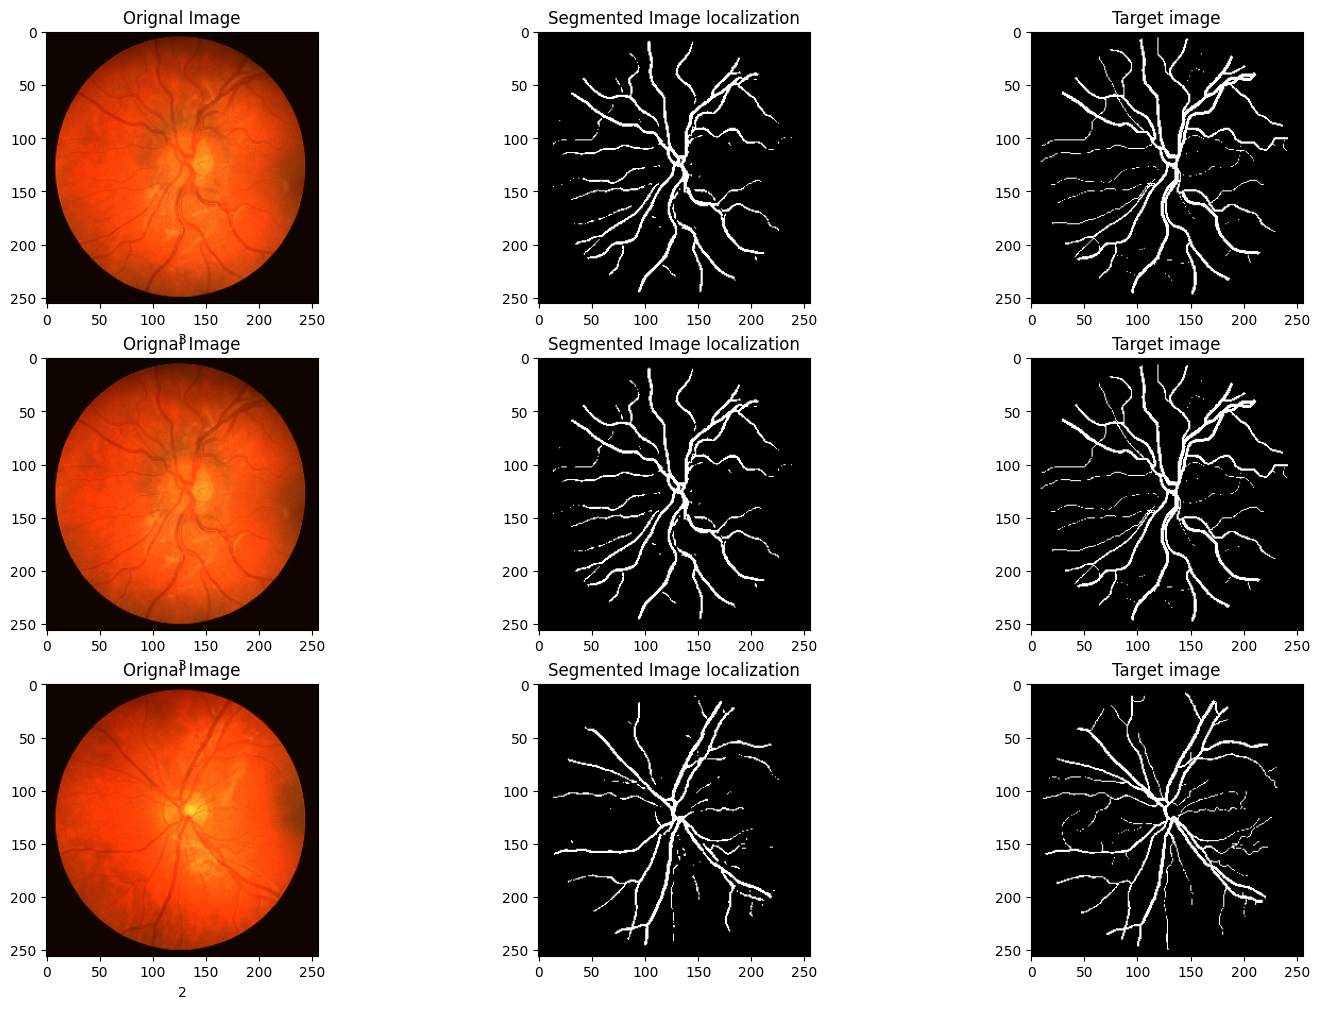



  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:02<?, ?it/s, loss=0.135, iou=0.612, dice=0.731, jaccard=0.608, ACC=0.967, SE=0.724, SP=0.986, pre=0.791, F1=0.756, MCC=0.74, GMean=0.845]

 50%|█████     | 1/2 [00:02<00:02,  2.84s/it, loss=0.135, iou=0.612, dice=0.731, jaccard=0.608, ACC=0.967, SE=0.724, SP=0.986, pre=0.791, F1=0.756, MCC=0.74, GMean=0.845]

MCC Computation: TP=13320, TN=240238, FP=3514, FN=5072, MCC=0.7395718938067312




 50%|█████     | 1/2 [00:03<00:02,  2.84s/it, loss=0.135, iou=0.608, dice=0.728, jaccard=0.603, ACC=0.967, SE=0.709, SP=0.987, pre=0.802, F1=0.753, MCC=0.737, GMean=0.836]

100%|██████████| 2/2 [00:04<00:00,  2.08s/it, loss=0.135, iou=0.608, dice=0.728, jaccard=0.603, ACC=0.967, SE=0.709, SP=0.987, pre=0.802, F1=0.753, MCC=0.737, GMean=0.836]

 50%|█████     | 1/2 [00:10<00:10, 10.16s/it]

MCC Computation: TP=6497, TN=120128, FP=1384, FN=3063, MCC=0.7309254687787624
Metrics on test set:
loss: 0.1350
iou: 0.6081
dice: 0.7278
jaccard: 0.6033
ACC: 0.9669
SE: 0.7094
SP: 0.9866
pre: 0.8023
F1: 0.7525
MCC: 0.7367
GMean: 0.8365


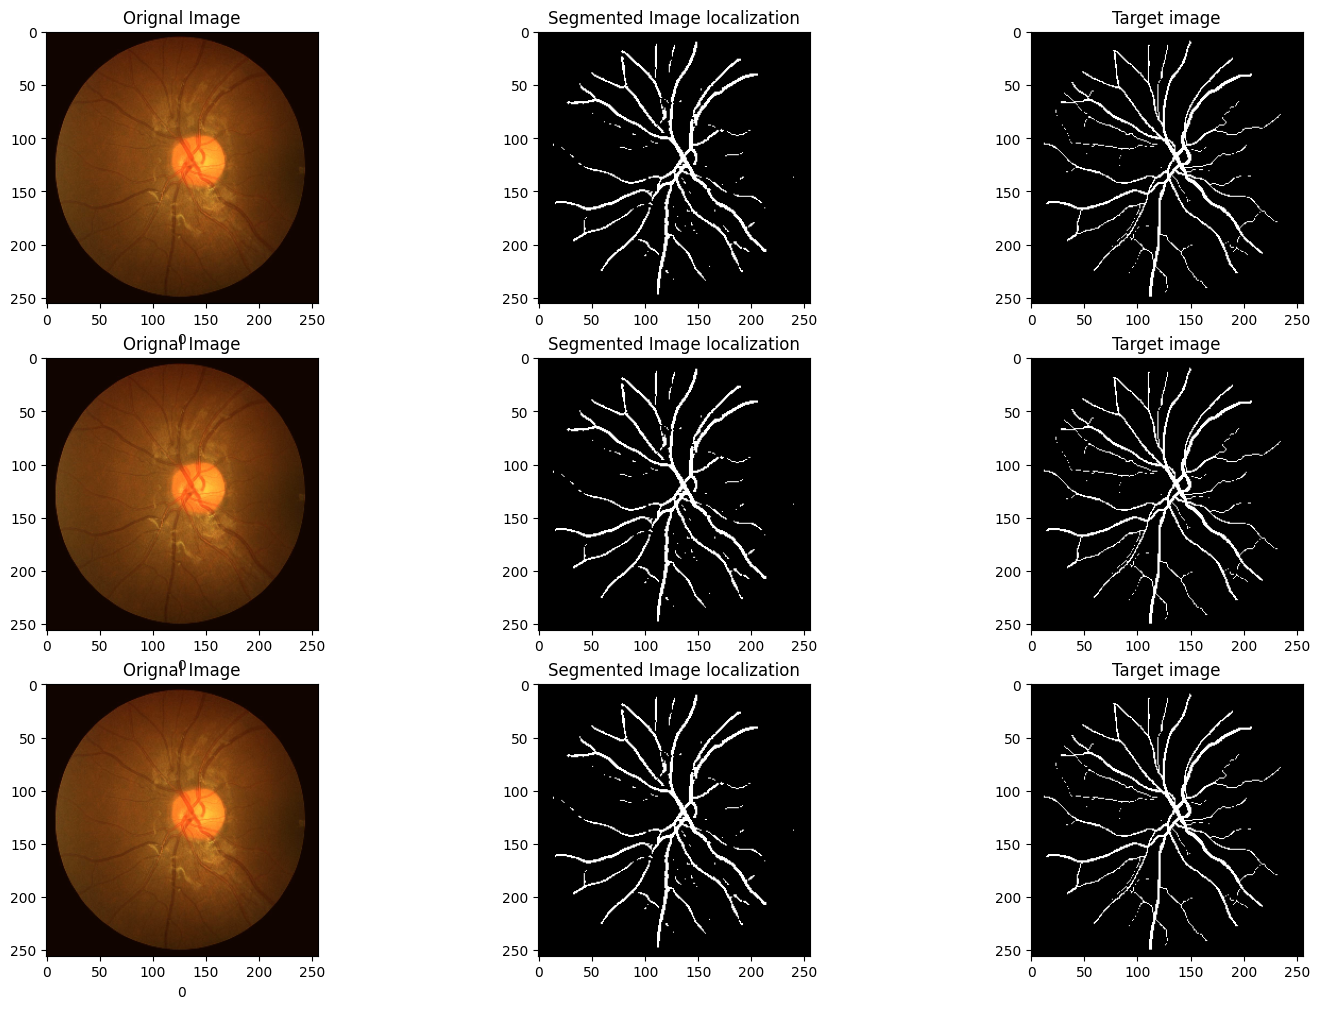



  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:02<?, ?it/s, loss=0.136, iou=0.609, dice=0.729, jaccard=0.604, ACC=0.967, SE=0.712, SP=0.986, pre=0.799, F1=0.753, MCC=0.737, GMean=0.838]

 50%|█████     | 1/2 [00:02<00:02,  2.04s/it, loss=0.136, iou=0.609, dice=0.729, jaccard=0.604, ACC=0.967, SE=0.712, SP=0.986, pre=0.799, F1=0.753, MCC=0.737, GMean=0.838]

MCC Computation: TP=13317, TN=240090, FP=3347, FN=5390, MCC=0.7365971182798083




 50%|█████     | 1/2 [00:02<00:02,  2.04s/it, loss=0.135, iou=0.608, dice=0.728, jaccard=0.603, ACC=0.967, SE=0.709, SP=0.987, pre=0.802, F1=0.753, MCC=0.736, GMean=0.836]

100%|██████████| 2/2 [00:02<00:00,  1.47s/it, loss=0.135, iou=0.608, dice=0.728, jaccard=0.603, ACC=0.967, SE=0.709, SP=0.987, pre=0.802, F1=0.753, MCC=0.736, GMean=0.836]

100%|██████████| 2/2 [00:19<00:00,  9.47s/it]

MCC Computation: TP=6500, TN=120276, FP=1551, FN=2745, MCC=0.7361749163499085
Metrics on test set:
loss: 0.1350
iou: 0.6080
dice: 0.7278
jaccard: 0.6032
ACC: 0.9669
SE: 0.7089
SP: 0.9866
pre: 0.8019
F1: 0.7525
MCC: 0.7365
GMean: 0.8363


100%|██████████| 2/2 [00:19<00:00,  9.65s/it]


In [ ]:
import argparse
import os
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
import cv2
import torch
import torch.backends.cudnn as cudnn
import yaml
from albumentations.augmentations import transforms
from albumentations.core.composition import Compose
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import csv


# import archs
# from dataset import Dataset
# from metrics import iou_score
# from utils import AverageMeter
import albumentations as albu
"""
需要指定参数：--name dsb2018_96_UNet_woDS
"""

def parse_args():
    parser = argparse.ArgumentParser()

    parser.add_argument('--name', default='explo',  # Provide a default value here
                        help='model name')

    args = parser.parse_args('')  # Pass an empty string to parse_args
    return args


def test_params(config, val_loader, model, criterion):
    avg_meters = {'loss': AverageMeter(),
                  'iou': AverageMeter(),
                  'dice': AverageMeter(),
                  'jaccard': AverageMeter(),
                  'ACC': AverageMeter(),
                  'SE': AverageMeter(),
                  'SP': AverageMeter(),
                  'pre': AverageMeter(),
                  'F1': AverageMeter(),
                  'MCC': AverageMeter(),
                  'GMean': AverageMeter(),
                  }

    # switch to evaluate mode
    model.eval()

    with torch.no_grad():
        pbar = tqdm(total=len(val_loader))
        for input, target, _ in val_loader:
            # input = input.cuda()
            input = input.to(device)
            # target = target.cuda()
            target = target.to(device)

            # compute output
            if config['deep_supervision']:
                outputs = model(input)
                loss = 0
                for output in outputs:
                    loss += criterion(output, target)
                loss /= len(outputs)
                iou = iou_score(outputs[-1], target)
                dice = dice_coef(outputs[-1], target)
                jaccard = jac(outputs[-1], target)
                ACC = get_acc(outputs[-1], target)
                SE = get_sensitivity(outputs[-1], target)
                SP = get_specificity(outputs[-1], target)
                pre = get_precision(outputs[-1], target)
                F1 = get_F1(outputs[-1], target)
                MCC = get_mcc(outputs[-1], target)
                GMean = get_gmean(SE, SP)

            else:
                output = model(input)

                loss = criterion(output, target)
                iou = iou_score(output, target)
                dice = dice_coef(output, target)
                jaccard = jac(output, target)
                ACC = get_acc(output, target)
                SE = get_sensitivity(output, target)
                SP = get_specificity(output, target)
                pre = get_precision(output, target)
                F1 = get_F1(output, target)
                MCC = get_mcc(output, target)
                GMean = get_gmean(SE, SP)

            avg_meters['loss'].update(loss.item(), input.size(0))
            avg_meters['iou'].update(iou, input.size(0))
            avg_meters['dice'].update(dice, input.size(0))
            avg_meters['jaccard'].update(jaccard, input.size(0))
            avg_meters['ACC'].update(ACC, input.size(0))
            avg_meters['SE'].update(SE, input.size(0))
            avg_meters['SP'].update(SP, input.size(0))
            avg_meters['pre'].update(pre, input.size(0))
            avg_meters['F1'].update(F1, input.size(0))
            avg_meters['MCC'].update(MCC, input.size(0))
            avg_meters['GMean'].update(GMean, input.size(0))

            postfix = OrderedDict([
                ('loss', avg_meters['loss'].avg),
                ('iou', avg_meters['iou'].avg),
                ('dice', avg_meters['dice'].avg),
                ('jaccard', avg_meters['jaccard'].avg),
                ('ACC', avg_meters['ACC'].avg),
                ('SE', avg_meters['SE'].avg),
                ('SP', avg_meters['SP'].avg),
                ('pre', avg_meters['pre'].avg),
                ('F1', avg_meters['F1'].avg),
                ('MCC', avg_meters['MCC'].avg),
                ('GMean', avg_meters['GMean'].avg),
            ])
            pbar.set_postfix(postfix)
            pbar.update(1)
        pbar.close()

    return OrderedDict([('loss', avg_meters['loss'].avg),
                        ('iou', avg_meters['iou'].avg),
                        ('dice', avg_meters['dice'].avg),
                        ('jaccard', avg_meters['jaccard'].avg),
                        ('ACC', avg_meters['ACC'].avg),
                        ('SE', avg_meters['SE'].avg),
                        ('SP', avg_meters['SP'].avg),
                        ('pre', avg_meters['pre'].avg),
                        ('F1', avg_meters['F1'].avg),
                        ('MCC', avg_meters['MCC'].avg),
                        ('GMean', avg_meters['GMean'].avg),
                        ])




def main():
    args = parse_args()

    # with open('models/dsb2018_96_UNet_woDS/config.yml', 'r') as f:
    #     config = yaml.load(f, Loader=yaml.FullLoader)
    config = {
        'arch': 'DualA_Net',
        'epochs': '75(lr=1e-3)',
        'dataset': 'chase_db1',
        'img_ext': '.jpg',
        'mask_ext': '.png',
        'num_classes': 1,
        'input_channels': 3,
        'input_h': 256,
        'input_w': 256,
        'deep_supervision': False,
        'name': 'explo',
        'batch_size':4,
        'num_workers':2
    }
    print('-'*20)
    for key in config.keys():
        print('%s: %s' % (key, str(config[key])))
    print('-'*20)

    criterion = nn.BCEWithLogitsLoss().to(device)
    cudnn.benchmark = True


    # create model
    print("=> creating model %s" % config['arch'])
    model = DualA_Net(config['num_classes'],
                                           config['input_channels'],
                                           config['deep_supervision'])


    # model = model.cuda()

    # Data loading code
    img_ids = glob(os.path.join('/content/extracted_files', config['dataset'], 'images', '*' + config['img_ext']))
    img_ids = [os.path.splitext(os.path.basename(p))[0] for p in img_ids]

    # _, val_img_ids = train_test_split(img_ids, test_size=0.2, random_state=41)
    train_img_ids, test_img_ids = train_test_split(img_ids, test_size=0.2, random_state=41)
    train_img_ids, val_img_ids = train_test_split(train_img_ids, test_size=0.2, random_state=41)


    model.load_state_dict(torch.load('/content/models/chase_db1_DualA_Net_woDS/model.pth'))

    model.eval()

    test_transform = Compose([
        albu.Resize(config['input_h'], config['input_w']),
        albu.Normalize(),
    ])

    test_dataset = Dataset(
        img_ids=test_img_ids,
        img_dir='/content/extracted_files/chase_db1/images',
        mask_dir='/content/extracted_files/chase_db1/masks',
        img_ext=config['img_ext'],
        mask_ext=config['mask_ext'],
        num_classes=config['num_classes'],
        transform=test_transform)
    test_loader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=config['batch_size'],
        shuffle=True,
        num_workers=config['num_workers'],
        drop_last=False)

    # avg_meter = AverageMeter()
    avg_meter = test_params(config, test_loader, model, criterion)



    for c in range(config['num_classes']):
        os.makedirs(os.path.join('outputs', config['name'], str(c)), exist_ok=True)
    with torch.no_grad():
        for input, target, meta in tqdm(test_loader, total=len(test_loader)):
            # input = input.cuda()
            # target = target.cuda()

            # compute output
            if config['deep_supervision']:
                output = model(input)[-1]
            else:
                output = model(input)



            output = torch.sigmoid(output).cpu().numpy()

            for i in range(len(output)):
                for c in range(config['num_classes']):
                    cv2.imwrite(os.path.join('outputs', config['name'], str(c), meta['img_id'][i] + '.jpg'),
                                (output[i, c] * 255).astype('uint8'))

            plot_examples(input, target, model, num_examples=3)
            metrics = test_params(config, test_loader, model, criterion)
            print("Metrics on test set:")
            for key, value in metrics.items():
                print(f"{key}: {value:.4f}")

    # print('\nIoU: %.4f' % avg_meter.avg)

    def append_to_csv(filename='data.csv', data=None):
          file_exists = os.path.isfile(filename)
          with open(filename, 'a', newline='') as csvfile:
              writer = csv.writer(csvfile)
              if not file_exists:
                  writer.writerow(['epochs', 'height', 'width', 'iou', 'dice', 'jaccard', 'SE', 'SP', 'ACC', 'precision', 'F1'])
              if data:
                  writer.writerows(data)


    data = [
        [config['epochs'], config['input_h'], config['input_w'],
         metrics['iou'], metrics['dice'], metrics['jaccard'],
         metrics['SE'], metrics['SP'], metrics['ACC'], metrics['pre'], metrics['F1'],
         metrics['MCC'], metrics['GMean']]
    ]

    # Convert dictionary data to list of lists

    append_to_csv('my_data.csv', data)




    torch.cuda.empty_cache()

def plot_examples(datax, datay, model,num_examples=1):
    fig, ax = plt.subplots(nrows=num_examples, ncols=3, figsize=(18,12))
    m = datax.shape[0]  #[4,3,256,256]
    # print(datax.shape)
    # print(m)
    for row_num in range(num_examples):
        image_indx = np.random.randint(m)  #返回一个随机整数型
        image_arr = model(datax[image_indx:image_indx+1]).squeeze(0).detach().cpu().numpy()

        image_data = np.transpose(datax[image_indx].cpu().numpy(), (1,2,0))
        image_data_rgb = cv2.cvtColor(image_data, cv2.COLOR_BGR2RGB)  # Assuming it's BGR
        image_data_normalized = (image_data_rgb - image_data_rgb.min()) / (image_data_rgb.max() - image_data_rgb.min())
        ax[row_num][0].imshow(image_data_normalized)

        # ax[row_num][0].imshow(np.transpose(datax[image_indx].cpu().numpy(), (1,2,0))[:,:,0])
        ax[row_num][0].set_title("Orignal Image")
        ax[row_num][0].set_xlabel(image_indx)
        ax[row_num][1].imshow(np.squeeze((image_arr > 0.40)[0,:,:].astype(int)),cmap='gray')

        ax[row_num][1].set_title("Segmented Image localization")
        ax[row_num][2].imshow(np.transpose(datay[image_indx].cpu().numpy(), (1,2,0))[:,:,0],cmap='gray')
        ax[row_num][2].set_title("Target image")

    plt.savefig('./outputs/test.png', bbox_inches='tight')

    plt.show()


if __name__ == '__main__':
    main()
